# Loan Approval Classification — Notebook

Ce notebook effectue une Analyse Exploratoire des Données (Exploratory Data Analysis, EDA), le prétraitement, la sélection des features et propose différents modèles de classification des données.

## About Dataset
### 1. Data Source

This dataset is a synthetic version inspired by the original Credit Risk dataset on Kaggle and enriched with additional variables based on Financial Risk for Loan Approval data. SMOTENC was used to simulate new data points to enlarge the instances. The dataset is structured for both categorical and continuous features.

### 2. Metadata

Le dataset contient **45 000 observations** et **14 variables**.

#### Variables numériques (9)

| Variable | Description | Type |
|----------|-------------|------|
| `person_age` | Âge de la personne | Float |
| `person_income` | Revenu annuel | Float |
| `person_emp_exp` | Années d'expérience professionnelle | Integer |
| `loan_amnt` | Montant du prêt demandé | Float |
| `loan_int_rate` | Taux d'intérêt du prêt (%) | Float |
| `loan_percent_income` | Montant du prêt en % du revenu annuel | Float |
| `cb_person_cred_hist_length` | Durée de l'historique de crédit (années) | Float |
| `credit_score` | Score de crédit de la personne | Integer |
| **`loan_status`** *(target)* | **Statut d'approbation : 1 = approuvé, 0 = rejeté** | **Integer (binaire)** |

#### Variables catégorielles (5)

| Variable | Description | Modalités typiques |
|----------|-------------|-------------------|
| `person_gender` | Genre de la personne | Male, Female |
| `person_education` | Niveau d'éducation | High School, Bachelor, Master, Doctorate |
| `person_home_ownership` | Statut de propriété immobilière | Rent, Own, Mortgage, Other |
| `loan_intent` | Objectif du prêt | Education, Medical, Personal, Home Improvement, Debt Consolidation, Venture |
| `previous_loan_defaults_on_file` | Présence de défauts de paiement antérieurs | Yes, No |

### 3. Data Usage

The dataset can be used for multiple purposes:

- Exploratory Data Analysis (EDA): Analyze key features, distribution patterns, and relationships to understand credit risk factors.
- Classification: Build predictive models to classify the loan_status variable (approved/not approved) for potential applicants.
- Regression: Develop regression models to predict the credit_score variable based on individual and loan-related attributes.

Mind the data issue from the original data, such as the instance > 100-year-old as age.

This dataset provides a rich basis for understanding financial risk factors and simulating predictive modeling processes for loan approval and credit scoring.

## Contexte et objectifs

### Contexte

Ce notebook a pour but d'explorer un jeu de données de demandes de prêt, de préparer les données et d'entraîner des modèles de classification (Logistic Regression) pour prédire si un prêt est accordé (`loan_status`).

Étapes réalisées dans ce document :
- Chargement et vérification rapide des données
- Analyse exploratoire (EDA) des variables
- Rééquilibrage de la target (undersampling des classes majoritaires)
- Prétraitement (imputation, standardisation, encodage) via une pipeline
- Sélection simple de features (corrélation)
- Entraînement de pipeline avec GridSearchCV pour les différents modèles
- Évaluation et sauvegarde du modèle

### Objectifs

Les modèles de classification peuvent être évalués suivant plusieurs métriques. Les plus connues d'entre elles sont la précision et le rappel (precision and recall). Le F1-score est une combinaison des deux tel que :

$$F1 = \frac{2}{\frac{1}{\text{Precision}} + \frac{1}{\text{Recall}}}$$


$$F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

Où :
- **Precision** = $\frac{TP}{TP + FP}$ (proportion de prédictions positives correctes)
- **Recall** = $\frac{TP}{TP + FN}$ (proportion de vrais positifs détectés)
- TP = True Positives, FP = False Positives, FN = False Negatives

Le F1-score est la moyenne harmonique de la précision et du rappel, et atteint sa meilleure valeur à 1 (perfection) et sa pire à 0.


##### Pourquoi utilise-t-on le F1 score dans notre cas ?

Pour la banque, le plus important est une garantie de remboursement du crédit accordé. Il faut donc un être strict sur l'accord de celui-ci. On doit donc avoir un recall élevé.

En revanche, d'un point de vue morale, pour des questions d'attractivité de clientelle, la banque se doit aussi d'accorder des prêts.

On doit donc avoir un équilibre entre le recall et la précision : les deux sont importants et doivent afficher des scores élevés.


#### Objectif de F1 score

Quantitativement, on peut considérer notre modèle comme intéressant si le F1 est supérieur à 0.90, score pour lequel les recall et precision sont tous les deux hauts, garantissant à la fois une sécurité d'emprunt et une facilité d'acès à celui-ci.

$$F1 > 0.90$$

In [1]:
import os
import sys
import subprocess


def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Liste des packages requis
required_packages = [
    'numpy', 
    'pandas', 
    'matplotlib', 
    'seaborn', 
    'scikit-learn',
    'scipy',
    'xgboost',
    'lightgbm',
    'torch',
    'gdown',
    'joblib'
]

for package in required_packages:
    try:
        if package == 'scikit-learn':
            __import__('sklearn')
        elif package == 'torch':
            __import__('torch')
        else:
            __import__(package)
    except ImportError:
        print(f"Installation de {package}...")
        install_package(package)

# Imports standards
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Scipy
from scipy.stats import chi2_contingency, ttest_ind

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score,
    precision_recall_curve, average_precision_score, PrecisionRecallDisplay,
    roc_curve, roc_auc_score, RocCurveDisplay
)

# Modèles de boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Pandas plotting
from pandas.plotting import scatter_matrix

%matplotlib inline

### Chargement des données

Cette cellule charge le fichier CSV. Vérifiez le chemin `DATA_PATH`. Après le chargement, on affiche la dimension globale (`df.shape`) et un aperçu (`df.head()`). Si le fichier n'est pas trouvé, la cellule lève une erreur pour vous alerter.

In [2]:

# Obtenir le chemin du notebook
notebook_path = os.path.abspath('')
print(f"Répertoire actuel : {notebook_path}")

# Se placer dans le répertoire du notebook
os.chdir(notebook_path)
DATA_PATH = os.path.join(os.getcwd(),'loan_data.csv')
if not os.path.exists(DATA_PATH):
    import gdown
    # ID du fichier Google Drive (extrait du lien)
    file_id = '1aSRxZA8X0eRZAYoKwxuLLL98pBkmwc0Q'
    url = f'https://drive.google.com/uc?id={file_id}'
    
    # Télécharger le fichier
    gdown.download(url, DATA_PATH, quiet=False)
    
       
    
df = pd.read_csv(DATA_PATH)
print('Dimensions:', df.shape)
df.head()

Répertoire actuel : /home/onyxia/work
Dimensions: (45000, 14)


person_age person_gender person_education  person_income  person_emp_exp  \
0        22.0        female           Master        71948.0               0   
1        21.0        female      High School        12282.0               0   
2        25.0        female      High School        12438.0               3   
3        23.0        female         Bachelor        79753.0               0   
4        24.0          male           Master        66135.0               1   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT    35000.0    PERSONAL          16.02   
1                   OWN     1000.0   EDUCATION          11.14   
2              MORTGAGE     5500.0     MEDICAL          12.87   
3                  RENT    35000.0     MEDICAL          15.23   
4                  RENT    35000.0     MEDICAL          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.49                         3.0           561   
1                 0.08                         2.0           504   
2                 0.44                         3.0           635   
3                 0.44                         2.0           675   
4                 0.53                         4.0           586   

  previous_loan_defaults_on_file  loan_status  
0                             No            1  
1                            Yes            0  
2                             No            1  
3                             No            1  
4                             No            1

### Inspection rapide des types et des valeurs manquantes

Cette cellule :
- affiche le résumé `df.info()` (types et valeurs non-null)
- compte les valeurs manquantes par colonne
- convertit `person_age` en entier si présent (attention : perte d'infos si valeurs non-integers)
- construit deux listes `cat_cols` et `num_cols` basées sur le dtype (utile pour l'EDA et la construction de transformers)

In [3]:
# Aperçu rapide et types
display(df.info())
print('\nValeurs manquantes par colonne:\n', df.isnull().sum())
# convertir person_age si présent
if 'person_age' in df.columns:
    df['person_age'] = df['person_age'].astype(int)

# Détection simple des colonnes catégorielles vs numériques (basée sur dtype)
cat_cols = [c for c in df.columns if df[c].dtype == 'object']
num_cols = [c for c in df.columns if c not in cat_cols]
print('Colonnes catégorielles:', cat_cols)
print('Colonnes numériques:', num_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

None


Valeurs manquantes par colonne:
 person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64
Colonnes catégorielles: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Colonnes numériques: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_status']


### EDA : distributions et visualisations simples



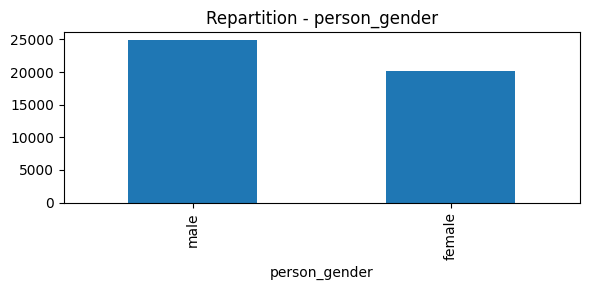

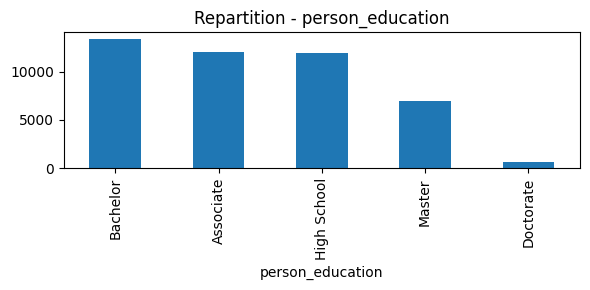

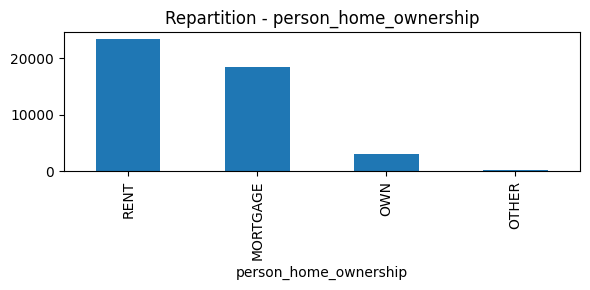

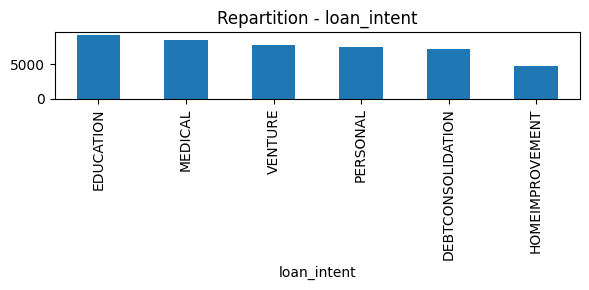

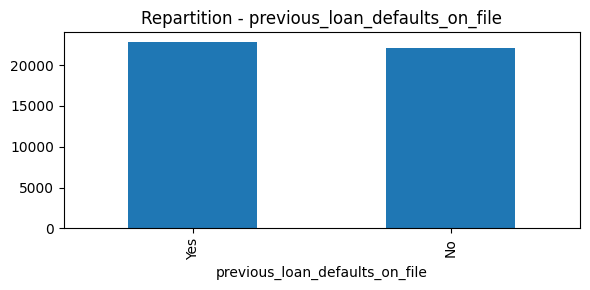

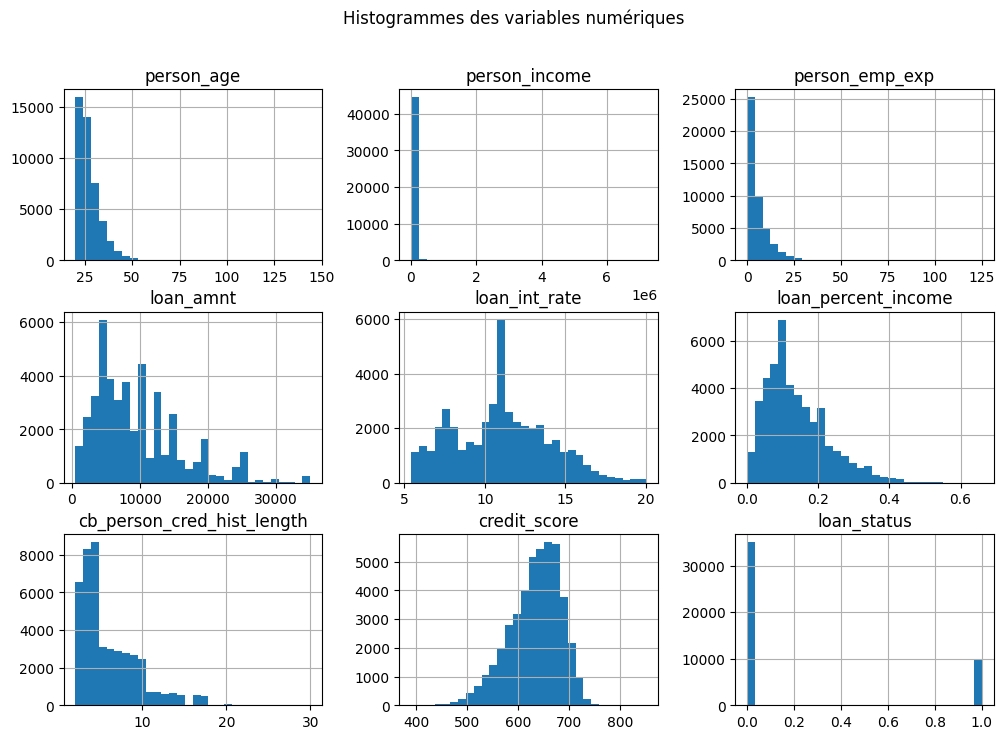

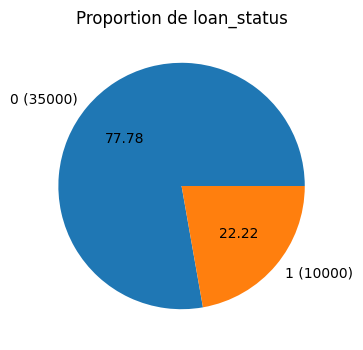

In [4]:
# EDA simple: distributions des catégorielles et des numériques
for c in cat_cols:
    plt.figure(figsize=(6,3))
    # value_counts() montre les modalités et leurs effectifs
    df[c].value_counts().plot(kind='bar', title=f'Repartition - {c}')
    plt.xlabel(c)
    plt.tight_layout()
    plt.show()

if num_cols:
    # histogrammes groupés pour repérer la forme des distributions
    df[num_cols].hist(bins=30, figsize=(12,8))
    plt.suptitle('Histogrammes des variables numériques')
    plt.show()

# Distribution de la target
if 'loan_status' in df.columns:
    counts = df['loan_status'].value_counts()
    plt.figure(figsize=(4,4))
    plt.pie(counts, labels=[str(i) + ' (' + str(n) + ')' for i,n in zip(counts.index, counts)], autopct='%.2f')
    plt.title('Proportion de loan_status')
    plt.show()


### Rééquilibrage de la target — pourquoi l'undersampling ?

Ici, nous choisissons d'équilibrer la target `loan_status` par undersampling des classes majoritaires (réduction du nombre d'exemples des classes abondantes) afin d'obtenir des classes approximativement équilibrées.

Points importants :
- L'undersampling évite d'ajouter des exemples synthétiques mais réduit la taille totale du jeu de données.
- Si la classe minoritaire est très petite, l'undersampling peut trop appauvrir l'entraînement.
- Alternative : l'upsampling, SMOTE, ou l'utilisation de `class_weight='balanced'` dans les modèles. On ne l'utilisera pas ici


In [5]:
# Rééquilibrage de la target `loan_status` à ~50/50 via undersampling (suppression d'exemples des classes majoritaires)

print('Distribution avant (counts):')
print(df['loan_status'].value_counts(dropna=False))

counts = df['loan_status'].value_counts()
min_n = counts.min()
parts = []
for cls, n in counts.items():
    subset = df[df['loan_status'] == cls]
    if n > min_n:
        # Sous-échantillonnage de la classe majoritaire jusqu'à min_n (sans remplacement)
        subset = subset.sample(n=min_n, replace=False, random_state=42)
    parts.append(subset)
df = pd.concat(parts, axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
print('Distribution après (équilibrée):')
print(df['loan_status'].value_counts())


Distribution avant (counts):
loan_status
0    35000
1    10000
Name: count, dtype: int64
Distribution après (équilibrée):
loan_status
1    10000
0    10000
Name: count, dtype: int64


## Études des corrélations potentiels

Nous pouvons supposer que certains groupes sociaux sont plus enclins à avoir bénéficier d'accord pour un emprunt.

Par exemple, certains facteurs comme l'éducation, le montant emprunté, le montant par rapport au salaire, le score crédit de la personne peuvent directement avoir une influence sur l'emprunt.

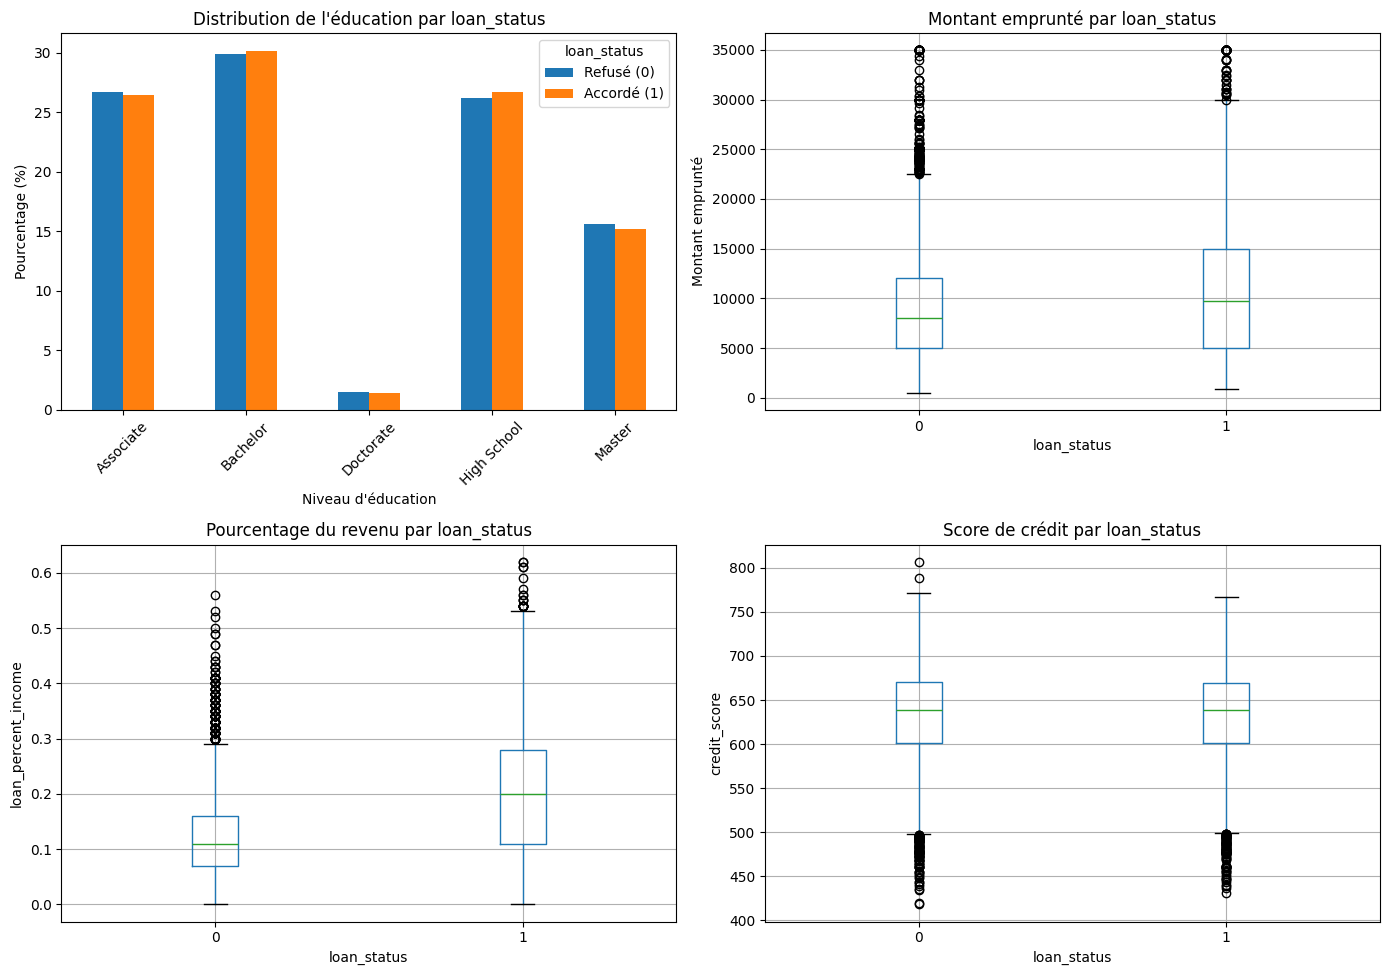

In [6]:
# Analyse de la corrélation entre loan_status et différentes variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Éducation vs loan_status
ax1 = axes[0, 0]
education_status = pd.crosstab(df['loan_status'], df['person_education'], normalize='index') * 100
education_status.T.plot(kind='bar', ax=ax1)
ax1.set_title('Distribution de l\'éducation par loan_status')
ax1.set_xlabel('Niveau d\'éducation')
ax1.set_ylabel('Pourcentage (%)')
ax1.legend(title='loan_status', labels=['Refusé (0)', 'Accordé (1)'])
ax1.tick_params(axis='x', rotation=45)

# 2. Montant emprunté vs loan_status
ax2 = axes[0, 1]
df.boxplot(column='loan_amnt', by='loan_status', ax=ax2)
ax2.set_title('Montant emprunté par loan_status')
ax2.set_xlabel('loan_status')
ax2.set_ylabel('Montant emprunté')
ax2.get_figure().suptitle('')

# 3. Pourcentage du revenu vs loan_status
ax3 = axes[1, 0]
df.boxplot(column='loan_percent_income', by='loan_status', ax=ax3)
ax3.set_title('Pourcentage du revenu par loan_status')
ax3.set_xlabel('loan_status')
ax3.set_ylabel('loan_percent_income')
ax3.get_figure().suptitle('')

# 4. Score de crédit vs loan_status
ax4 = axes[1, 1]
df.boxplot(column='credit_score', by='loan_status', ax=ax4)
ax4.set_title('Score de crédit par loan_status')
ax4.set_xlabel('loan_status')
ax4.set_ylabel('credit_score')
ax4.get_figure().suptitle('')

plt.tight_layout()
plt.show()

Pas vraiment de corrélation...

## Méthodes d'analyse de corrélation

Pour comprendre les relations entre les variables et la target `loan_status`, nous utilisons **trois approches complémentaires** permettant d'analyser respectivement les variables numériques et catégorielles.

---

### 1. Corrélation de Pearson (Variables numériques)

#### Définition

Le coefficient de corrélation de Pearson mesure l'intensité et la direction de la relation **linéaire** entre deux variables quantitatives.

#### Formule mathématique

$$r_{X,Y} = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2} \cdot \sqrt{\sum_{i=1}^{n}(y_i - \bar{y})^2}}$$

**Où :**
- $r_{X,Y}$ : coefficient de corrélation de Pearson entre les variables X et Y
- $n$ : nombre d'observations
- $x_i$ : valeur de la variable X pour l'observation i
- $y_i$ : valeur de la variable Y pour l'observation i
- $\bar{x}$ : moyenne arithmétique de la variable X, calculée comme $\bar{x} = \frac{1}{n}\sum_{i=1}^{n}x_i$
- $\bar{y}$ : moyenne arithmétique de la variable Y, calculée comme $\bar{y} = \frac{1}{n}\sum_{i=1}^{n}y_i$

#### Interprétation des valeurs

| Valeur de r | Interprétation |
|-------------|----------------|
| r = 1 | Corrélation positive parfaite (relation linéaire croissante) |
| 0.7 ≤ r < 1 | Corrélation positive forte |
| 0.3 ≤ r < 0.7 | Corrélation positive modérée |
| 0 < r < 0.3 | Corrélation positive faible |
| r = 0 | Absence de corrélation linéaire |
| -0.3 < r < 0 | Corrélation négative faible |
| -0.7 < r ≤ -0.3 | Corrélation négative modérée |
| -1 < r ≤ -0.7 | Corrélation négative forte |
| r = -1 | Corrélation négative parfaite (relation linéaire décroissante) |

#### Hypothèses et limites

**Hypothèses :**
- Les deux variables doivent être quantitatives (continues ou discrètes)
- La relation entre les variables doit être linéaire
- Les données ne doivent pas présenter d'outliers extrêmes

**Limites importantes :**
- Ne détecte que les relations **linéaires** (relations non-linéaires ignorées)
- Sensible aux valeurs aberrantes qui peuvent fausser le coefficient
- Un coefficient de corrélation ne permet **pas** de conclure sur la causalité (corrélation ≠ causalité)
- Une corrélation nulle n'implique pas l'absence de relation (peut exister une relation non-linéaire)

#### Application dans notre étude

- **Heatmap** : visualisation globale des corrélations entre toutes les variables numériques du dataset
- **Corrélation avec loan_status** : identification des variables numériques les plus prédictives de l'approbation du prêt

---

### 2. Test du Chi² (χ²) - Variables catégorielles

#### Définition

Le test du Chi² d'indépendance est un test statistique permettant de déterminer si deux variables catégorielles sont indépendantes ou s'il existe une association significative entre elles.

#### Hypothèses statistiques

- **H₀** (hypothèse nulle) : les deux variables sont **indépendantes** (aucune association)
- **H₁** (hypothèse alternative) : les deux variables sont **dépendantes** (association significative)

#### Statistique de test

$$\chi^2 = \sum_{i=1}^{r} \sum_{j=1}^{c} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$$

**Où :**
- $\chi^2$ : statistique du Chi² calculée
- $r$ : nombre de lignes du tableau de contingence (nombre de modalités de la première variable)
- $c$ : nombre de colonnes du tableau de contingence (nombre de modalités de la seconde variable)
- $O_{ij}$ : fréquence **observée** dans la cellule (i, j), c'est-à-dire le nombre réel d'observations
- $E_{ij}$ : fréquence **attendue** dans la cellule (i, j) sous l'hypothèse d'indépendance

#### Calcul des fréquences attendues

Sous l'hypothèse d'indépendance (H₀), la fréquence attendue pour chaque cellule est calculée comme :

$$E_{ij} = \frac{(\text{total ligne } i) \times (\text{total colonne } j)}{\text{total général}}$$

Plus formellement :

$$E_{ij} = \frac{n_{i\cdot} \times n_{\cdot j}}{n}$$

**Où :**
- $n_{i\cdot}$ : somme marginale de la ligne i (total de la ligne)
- $n_{\cdot j}$ : somme marginale de la colonne j (total de la colonne)
- $n$ : effectif total (somme de toutes les observations)

#### Interprétation de la p-value

La p-value représente la probabilité d'observer une statistique χ² aussi extrême (ou plus) que celle calculée, si H₀ est vraie.

| p-value | Décision | Interprétation |
|---------|----------|----------------|
| p < 0.05 | Rejet de H₀ | Les variables sont significativement dépendantes (association statistiquement significative au seuil α = 5%) |
| p ≥ 0.05 | Non-rejet de H₀ | Pas de preuve suffisante d'une dépendance (les variables peuvent être considérées comme indépendantes) |

Note : Le seuil α = 0.05 est conventionnel mais peut être ajusté selon le contexte (0.01 ou 0.10).

#### Conditions d'application

- Les observations doivent être indépendantes
- Les effectifs attendus doivent être suffisamment grands : $E_{ij} \geq 5$ pour au moins 80% des cellules
- Si cette condition n'est pas respectée, utiliser le test exact de Fisher

#### Limites

- Le test du Chi² indique uniquement la **significativité** de l'association (existence d'un lien)
- Il ne mesure **pas l'intensité** de cette association
- Sensible à la taille de l'échantillon : avec un grand n, des associations faibles peuvent devenir significatives

---

### 3. Cramér's V - Intensité de l'association

#### Définition

Le V de Cramér est une mesure normalisée de l'intensité de l'association entre deux variables catégorielles. Il complète le test du Chi² en quantifiant la **force** de l'association détectée.

#### Formule de calcul

$$V = \sqrt{\frac{\chi^2}{n \times \min(r-1, c-1)}}$$

**Où :**
- $V$ : coefficient V de Cramér (compris entre 0 et 1)
- $\chi^2$ : statistique du Chi² calculée précédemment
- $n$ : nombre total d'observations
- $r$ : nombre de lignes du tableau de contingence
- $c$ : nombre de colonnes du tableau de contingence
- $\min(r-1, c-1)$ : le minimum entre (r-1) et (c-1), utilisé pour la normalisation

#### Interprétation des valeurs

| Valeur de V | Intensité de l'association |
|-------------|---------------------------|
| V = 0 | Aucune association (indépendance parfaite) |
| 0 < V < 0.1 | Association négligeable |
| 0.1 ≤ V < 0.3 | Association faible |
| 0.3 ≤ V < 0.5 | Association modérée |
| V ≥ 0.5 | Association forte |
| V = 1 | Association parfaite (dépendance complète) |

#### Avantages

- **Normalisation** : valeur comprise entre 0 et 1, permettant la comparaison entre différentes paires de variables
- **Interprétation intuitive** : plus V est élevé, plus l'association est forte
- **Complément du Chi²** : combine significativité (Chi²) et intensité (V de Cramér)

#### Différence avec le Chi²

| Critère | Chi² (p-value) | V de Cramér |
|---------|----------------|-------------|
| Nature | Test d'hypothèse | Mesure d'association |
| Réponse | Existe-t-il une association ? (oui/non) | Quelle est l'intensité de l'association ? |
| Interprétation | Significativité statistique | Force de la relation |
| Sensibilité à n | Très sensible (augmente avec n) | Peu sensible (normalisé) |

---

### Synthèse méthodologique

| Méthode | Type de variables | Ce qu'elle mesure | Valeur critique | Interprétation |
|---------|-------------------|-------------------|-----------------|----------------|
| **Pearson (r)** | Numérique ↔ Numérique | Force et direction de la relation linéaire | \|r\| > 0.5 | Forte corrélation linéaire |
| **Chi² (p-value)** | Catégorielle ↔ Catégorielle | Significativité statistique de la dépendance | p < 0.05 | Association statistiquement significative |
| **Cramér's V** | Catégorielle ↔ Catégorielle | Intensité de l'association | V > 0.3 | Association modérée à forte |

---

### Application au contexte bancaire

Dans notre étude de prédiction d'approbation de prêt, ces méthodes permettent d'identifier :

**Variables numériques (Pearson) :**
- Corrélation entre `credit_score` et `loan_status`
- Relation entre `loan_amnt` et `person_income`
- Impact de `loan_percent_income` sur l'approbation

**Variables catégorielles (Chi² et Cramér's V) :**
- Association entre `person_education` et `loan_status`
- Lien entre `loan_intent` et l'approbation du prêt
- Influence du `person_home_ownership` sur la décision

Cette analyse multidimensionnelle permet de sélectionner les features les plus pertinentes pour la modélisation prédictive.

---

### Références bibliographiques

- Pearson, K. (1895). "Notes on regression and inheritance in the case of two parents". *Proceedings of the Royal Society of London*, 58, 240-242.
- Pearson, K. (1900). "On the criterion that a given system of deviations from the probable in the case of a correlated system of variables is such that it can be reasonably supposed to have arisen from random sampling". *Philosophical Magazine*, 50(302), 157-175.
- Cramér, H. (1946). *Mathematical Methods of Statistics*. Princeton University Press.
- Cohen, J. (1988). *Statistical Power Analysis for the Behavioral Sciences* (2nd ed.). Routledge.

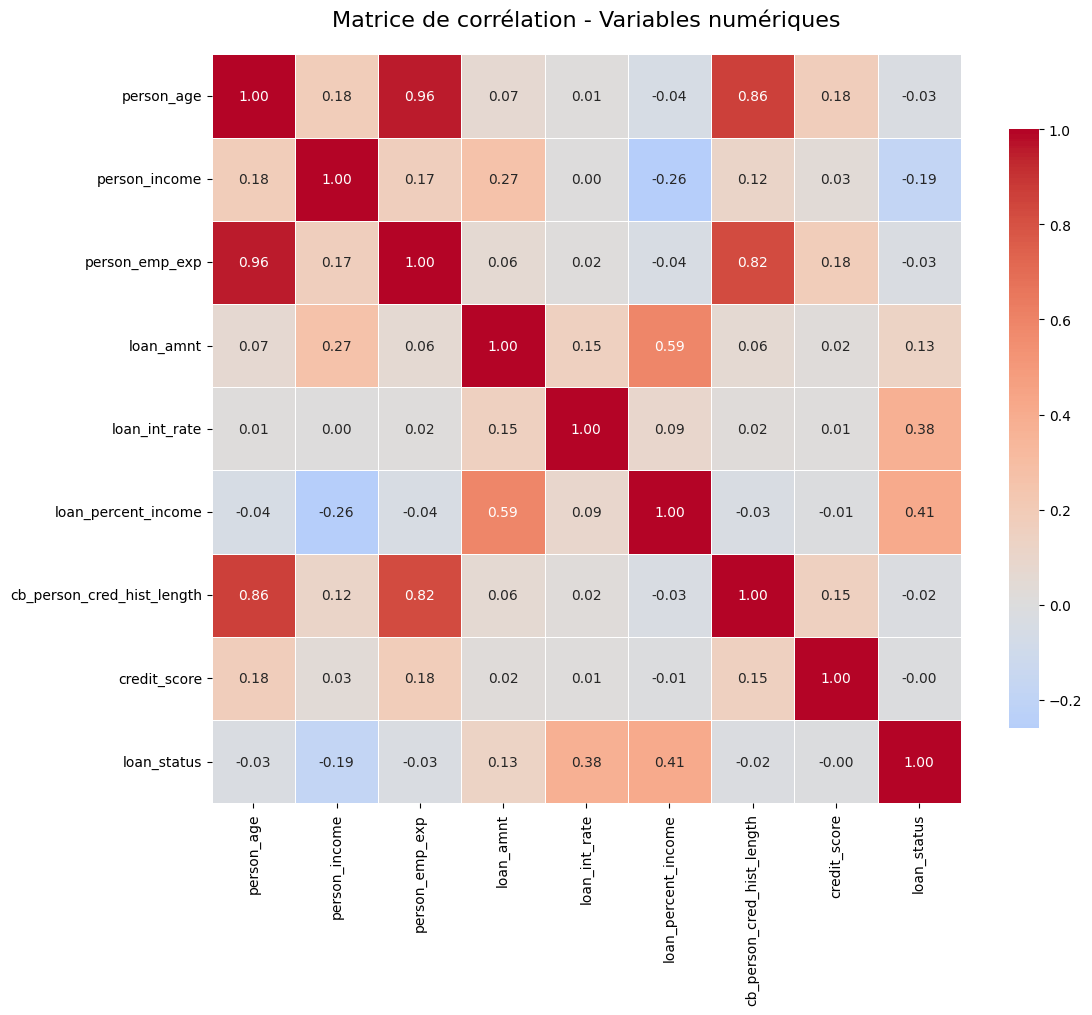


 Paires de variables fortement corrélées (|r| > 0.5):
  • person_age ↔ person_emp_exp: 0.955
  • person_age ↔ cb_person_cred_hist_length: 0.860
  • person_emp_exp ↔ cb_person_cred_hist_length: 0.823
  • loan_amnt ↔ loan_percent_income: 0.588


In [7]:
## Analyse approfondie des corrélations

### 1. Heatmap de corrélation (variables numériques)

import seaborn as sns

# Calculer la matrice de corrélation pour toutes les variables numériques
correlation_matrix = df[num_cols].corr()

# Créer la heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix, 
    annot=True,           # Afficher les valeurs
    fmt='.2f',            # Format des nombres (2 décimales)
    cmap='coolwarm',      # Palette de couleurs (bleu=négatif, rouge=positif)
    center=0,             # Centrer sur 0
    square=True,          # Cellules carrées
    linewidths=0.5,       # Lignes entre cellules
    cbar_kws={"shrink": 0.8}
)
plt.title('Matrice de corrélation - Variables numériques', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Identifier les corrélations fortes (hors diagonale)
print("\n Paires de variables fortement corrélées (|r| > 0.5):")
print("="*60)

# Extraire les corrélations fortes
strong_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.5:
            var1 = correlation_matrix.columns[i]
            var2 = correlation_matrix.columns[j]
            strong_corr.append((var1, var2, corr_value))

# Trier par valeur absolue décroissante
strong_corr.sort(key=lambda x: abs(x[2]), reverse=True)

if strong_corr:
    for var1, var2, corr in strong_corr:
        print(f"  • {var1} ↔ {var2}: {corr:.3f}")
else:
    print("  Aucune corrélation forte détectée (toutes < 0.5)")

array([[<Axes: xlabel='person_age', ylabel='person_age'>,
        <Axes: xlabel='person_emp_exp', ylabel='person_age'>],
       [<Axes: xlabel='person_age', ylabel='person_emp_exp'>,
        <Axes: xlabel='person_emp_exp', ylabel='person_emp_exp'>]],
      dtype=object)

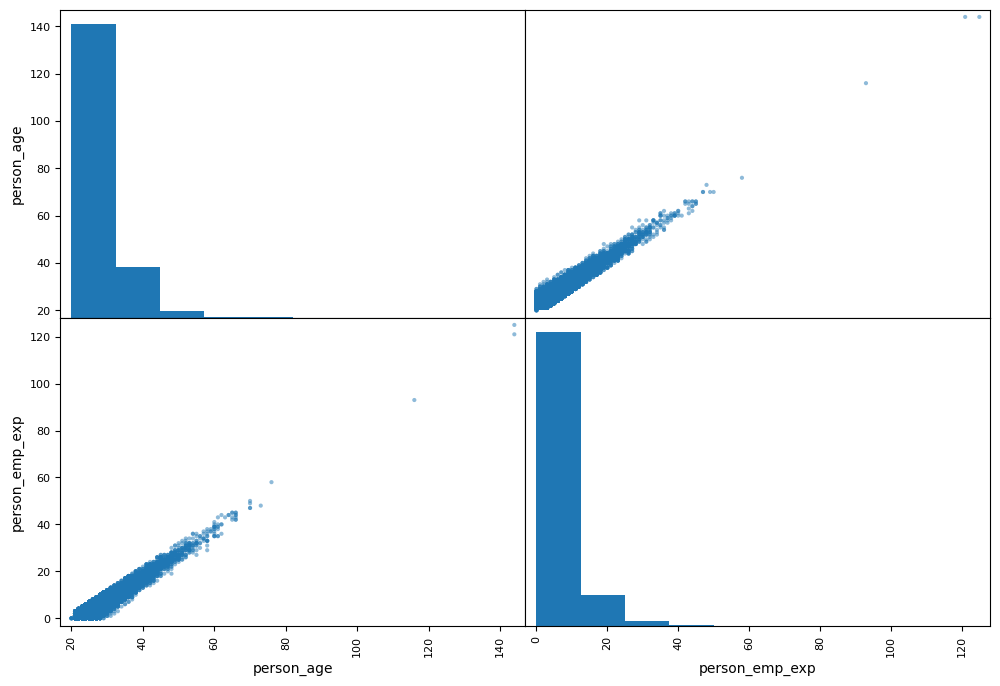

In [8]:
from pandas.plotting import scatter_matrix
scatter_matrix(df[["person_age", "person_emp_exp"]], figsize=(12,8))

C'est normal, il est logique que, plus une personne vieillisse, plus elle travaille. Il en est de même pour les deux autres corrélations croissante.


 Corrélation des variables numériques avec loan_status:
loan_status                   1.000000
loan_percent_income           0.408312
loan_int_rate                 0.378065
loan_amnt                     0.127048
credit_score                 -0.004529
cb_person_cred_hist_length   -0.020064
person_emp_exp               -0.026777
person_age                   -0.027542
person_income                -0.185783


<>:39: SyntaxWarning: invalid escape sequence '\ '
<>:39: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_40308/486260515.py:39: SyntaxWarning: invalid escape sequence '\ '
  print(f"\ Variables avec corrélation significative (|r| > 0.1): {len(significant_vars)-1}")


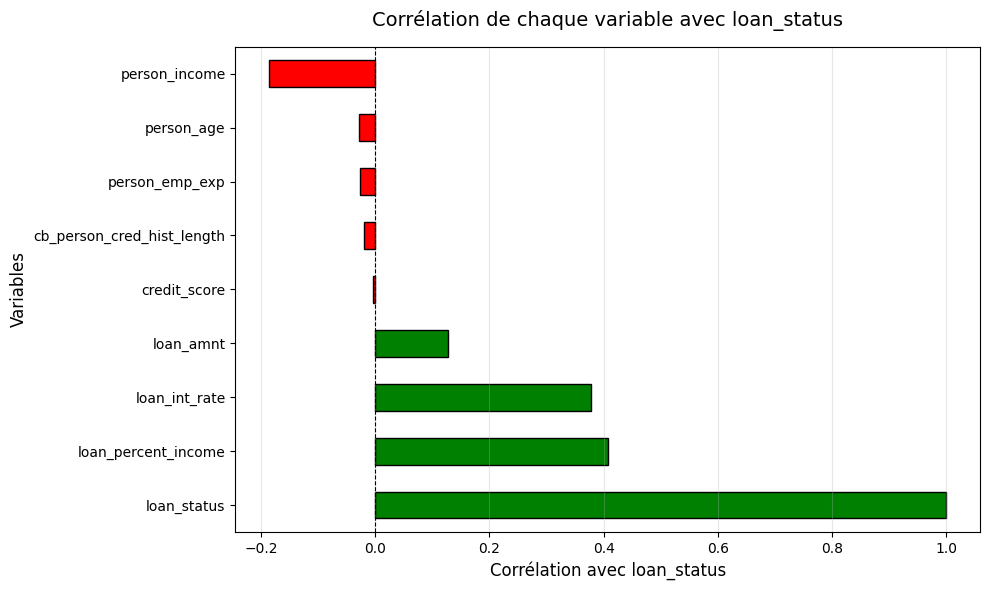


 Interprétation:

 Top 3 variables FAVORISANT l'approbation (corrélation positive):
  • loan_percent_income: 0.408
  • loan_int_rate: 0.378

 Top 3 variables DÉFAVORISANT l'approbation (corrélation négative):
  • person_emp_exp: -0.027
  • person_age: -0.028
  • person_income: -0.186
\ Variables avec corrélation significative (|r| > 0.1): 4


In [9]:
### 2. Corrélation avec loan_status uniquement

# Calculer la corrélation de toutes les variables numériques avec loan_status
correlations_with_target = df[num_cols].corrwith(df['loan_status']).sort_values(ascending=False)

# Afficher le tableau
print("\n Corrélation des variables numériques avec loan_status:")
print(correlations_with_target.to_string())

# Visualisation en barplot
plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in correlations_with_target.values]
correlations_with_target.plot(kind='barh', color=colors, edgecolor='black')
plt.xlabel('Corrélation avec loan_status', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.title('Corrélation de chaque variable avec loan_status', fontsize=14, pad=15)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Interpréter les résultats
print("\n Interprétation:")
top_positive = correlations_with_target.head(3)
top_negative = correlations_with_target.tail(3)

print("\n Top 3 variables FAVORISANT l'approbation (corrélation positive):")
for var, corr in top_positive.items():
    if var != 'loan_status':
        print(f"  • {var}: {corr:.3f}")
        
print("\n Top 3 variables DÉFAVORISANT l'approbation (corrélation négative):")
for var, corr in top_negative.items():
    if var != 'loan_status':
        print(f"  • {var}: {corr:.3f}")

# Seuil de significativité
significant_vars = correlations_with_target[abs(correlations_with_target) > 0.1]
print(f"\ Variables avec corrélation significative (|r| > 0.1): {len(significant_vars)-1}")

ANALYSE APPROFONDIE DES CORRÉLATIONS AVEC LOAN_STATUS

1. VARIABLES À CORRÉLATION POSITIVE (plus la valeur augmente, plus l'approbation augmente)

────────────────────────────────────────────────────────────────────────────────
Variable : loan_percent_income
Corrélation avec loan_status : 0.408

Statistiques descriptives par loan_status :
               count      mean       std  min   25%   50%   75%   max
loan_status                                                          
0            10000.0  0.121726  0.070497  0.0  0.07  0.11  0.16  0.56
1            10000.0  0.202521  0.106514  0.0  0.11  0.20  0.28  0.62

Test de Student (différence de moyennes) :
  • Statistique t : -63.254
  • p-value : 0.0000e+00
  • Conclusion : Différence SIGNIFICATIVE


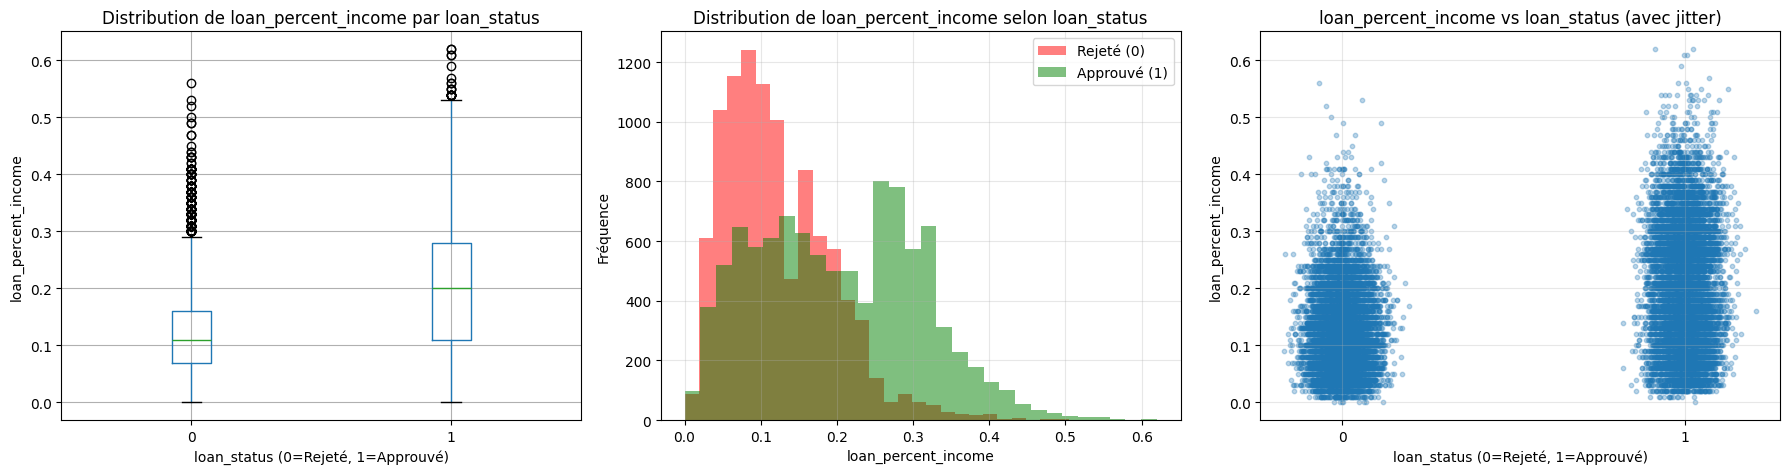


────────────────────────────────────────────────────────────────────────────────
Variable : loan_int_rate
Corrélation avec loan_status : 0.378

Statistiques descriptives par loan_status :
               count       mean       std   min      25%     50%      75%  \
loan_status                                                                 
0            10000.0  10.489786  2.717286  5.42   7.9075  10.885  12.2825   
1            10000.0  12.856794  3.068512  5.42  10.9900  12.980  15.2300   

              max  
loan_status        
0            20.0  
1            20.0  

Test de Student (différence de moyennes) :
  • Statistique t : -57.750
  • p-value : 0.0000e+00
  • Conclusion : Différence SIGNIFICATIVE


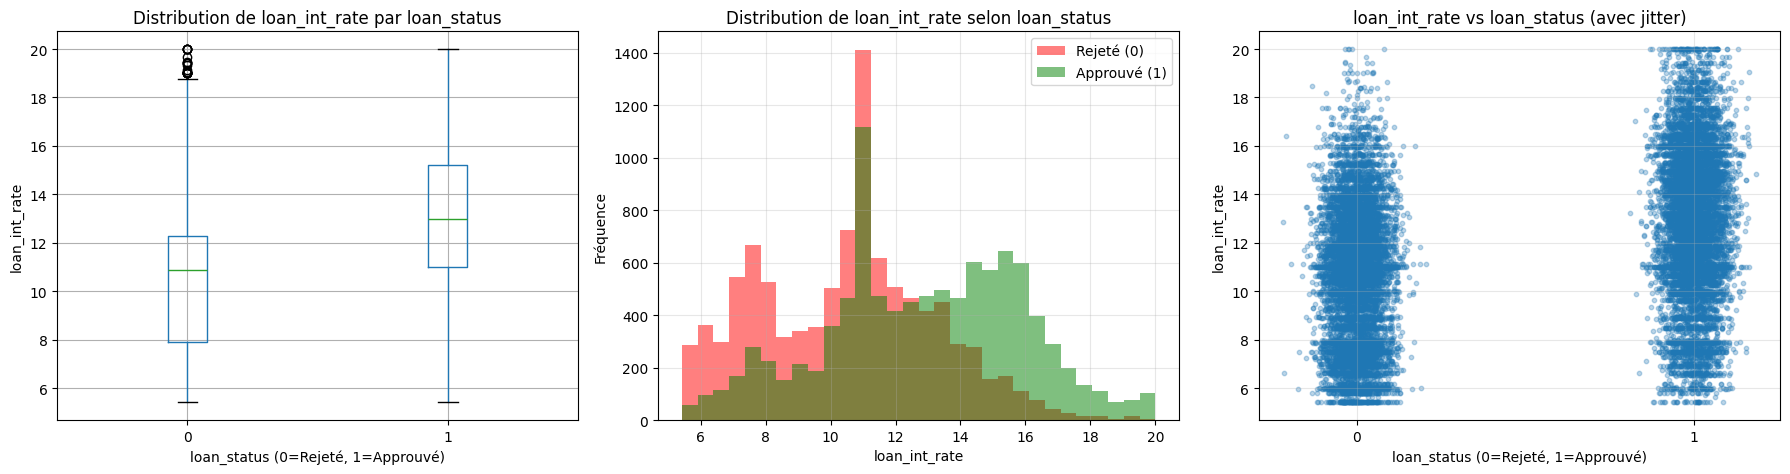

2. VARIABLES À CORRÉLATION NÉGATIVE (plus la valeur augmente, moins l'approbation augmente)
Variable : person_income
Corrélation avec loan_status : -0.186

Statistiques descriptives par loan_status :
               count        mean           std     min       25%      50%  \
loan_status                                                                 
0            10000.0  85299.2755  83535.317384  9732.0  51456.75  72915.0   
1            10000.0  59886.0969  45338.315604  8000.0  36841.75  50629.0   

                   75%        max  
loan_status                        
0            101957.25  5545545.0  
1             71888.25   845636.0  

Test de Student (différence de moyennes) :
  • Statistique t : 26.738
  • p-value : 8.9417e-155
  • Conclusion : Différence SIGNIFICATIVE


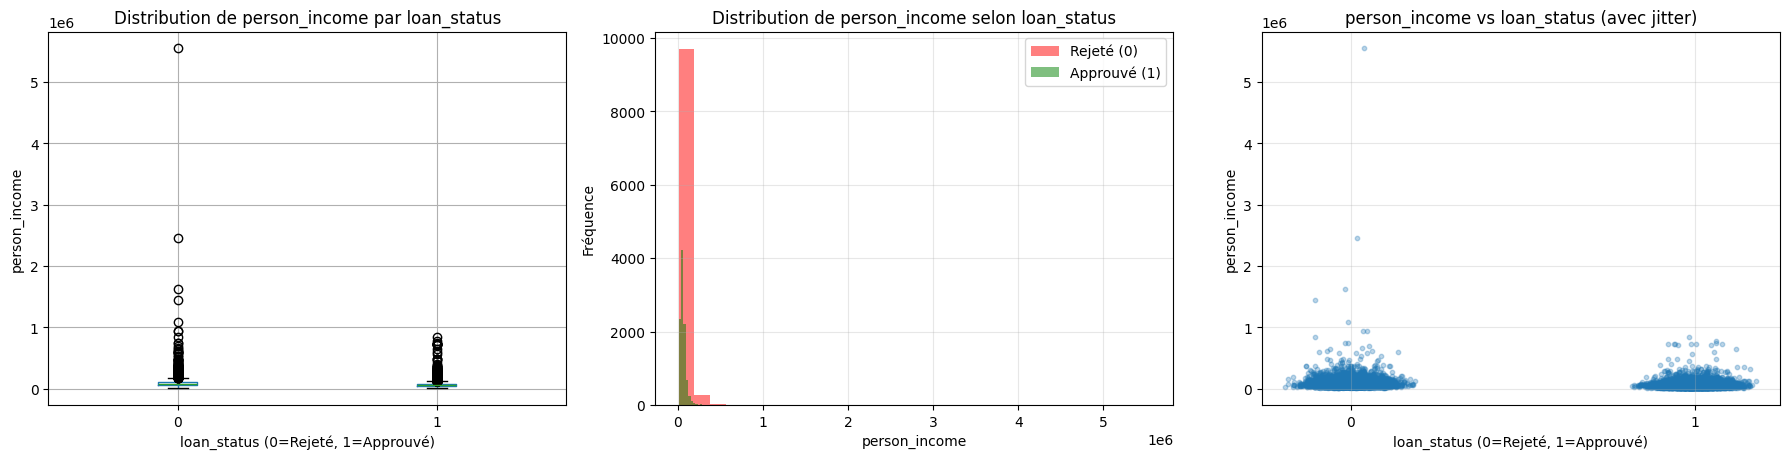

Variable : credit_score
Corrélation avec loan_status : -0.005

Statistiques descriptives par loan_status :
               count      mean        std    min    25%    50%    75%    max
loan_status                                                                 
0            10000.0  632.3449  50.759212  418.0  601.0  639.0  670.0  807.0
1            10000.0  631.8872  50.293485  431.0  601.0  639.0  669.0  767.0

Test de Student (différence de moyennes) :
  • Statistique t : 0.641
  • p-value : 5.2183e-01
  • Conclusion : Pas de différence significative


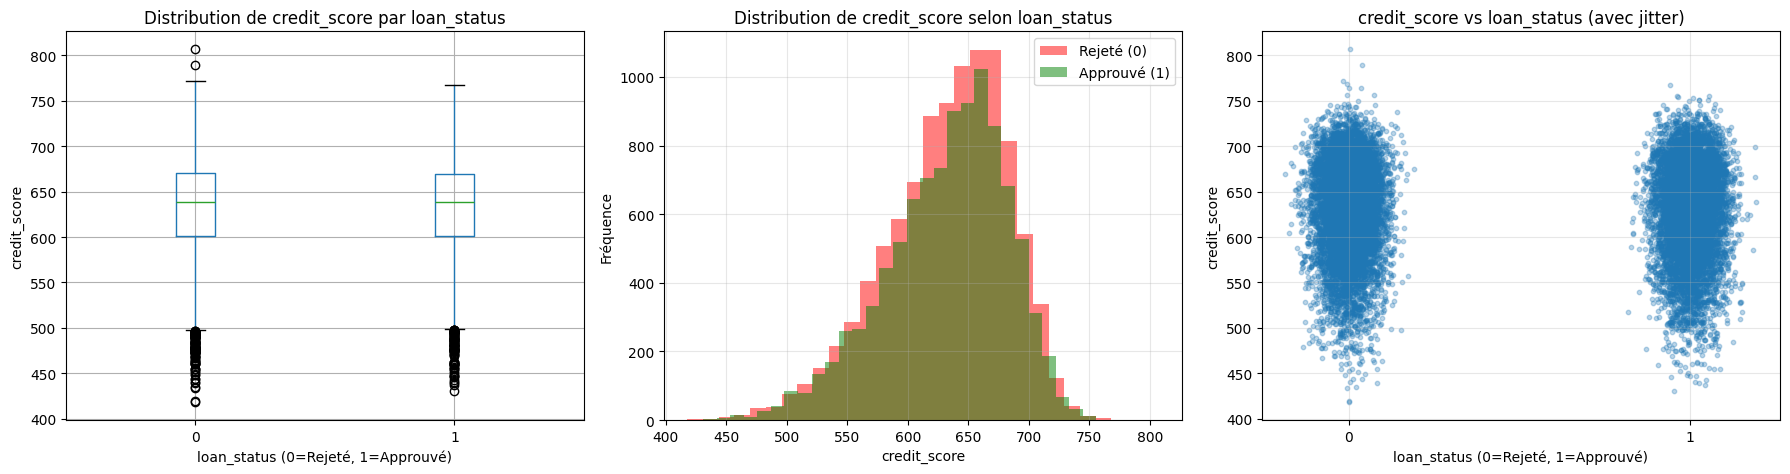

Variable : person_age
Corrélation avec loan_status : -0.028

Statistiques descriptives par loan_status :
               count     mean       std   min   25%   50%   75%    max
loan_status                                                           
0            10000.0  27.8568  6.234547  20.0  24.0  26.0  30.0  144.0
1            10000.0  27.5213  5.939063  20.0  23.0  26.0  30.0   70.0

Test de Student (différence de moyennes) :
  • Statistique t : 3.896
  • p-value : 9.7963e-05
  • Conclusion : Différence SIGNIFICATIVE


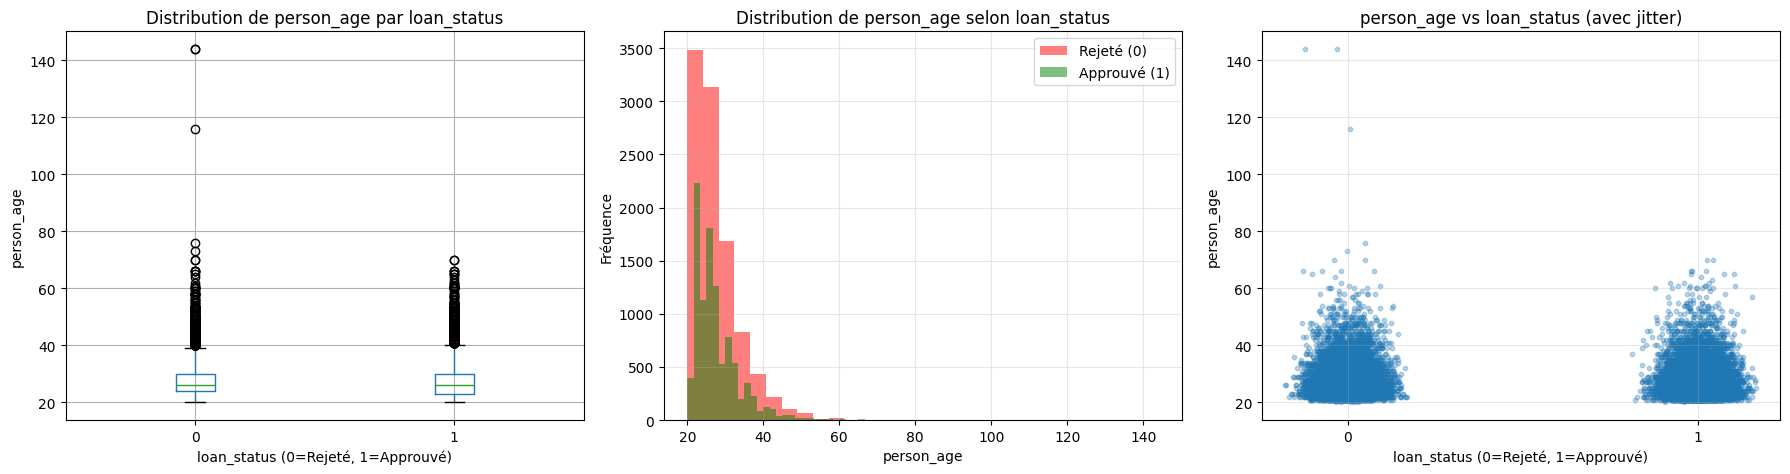

Variable : person_emp_exp
Corrélation avec loan_status : -0.027

Statistiques descriptives par loan_status :
               count    mean       std  min  25%  50%  75%    max
loan_status                                                      
0            10000.0  5.5052  6.296470  0.0  1.0  4.0  8.0  125.0
1            10000.0  5.1780  5.913207  0.0  1.0  3.0  8.0   47.0

Test de Student (différence de moyennes) :
  • Statistique t : 3.788
  • p-value : 1.5231e-04
  • Conclusion : Différence SIGNIFICATIVE


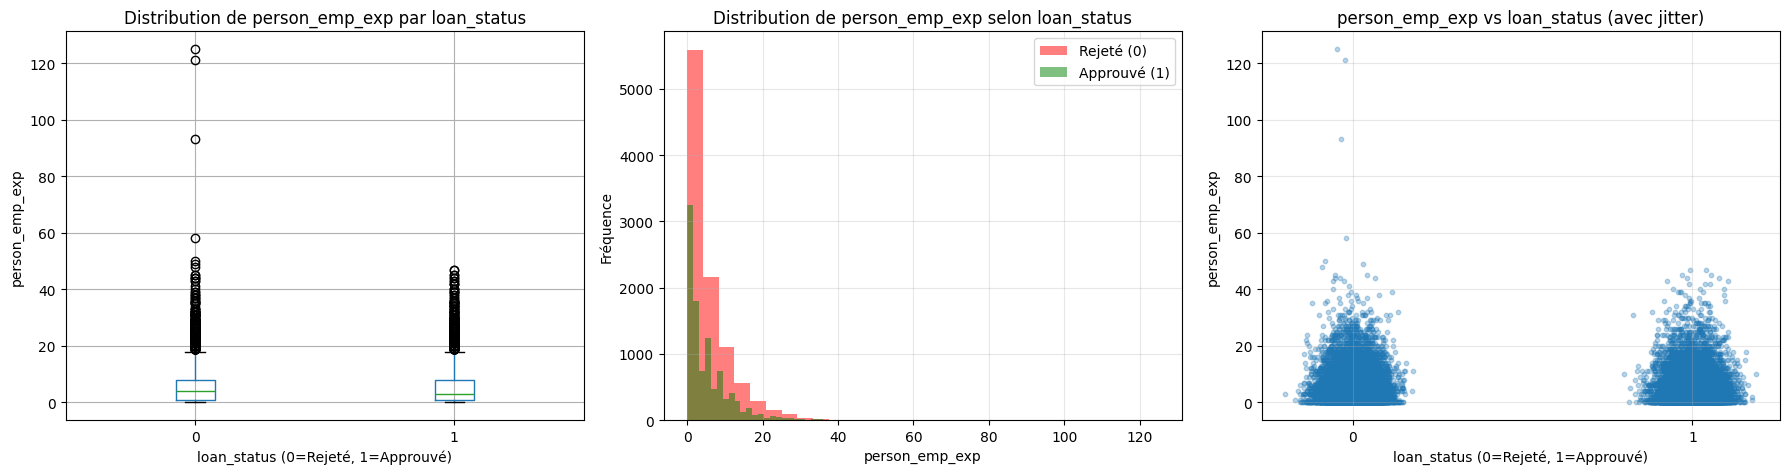



3. ANALYSE MULTIVARIÉE : INTERACTIONS ENTRE VARIABLES

Création d'un pairplot des variables significatives...


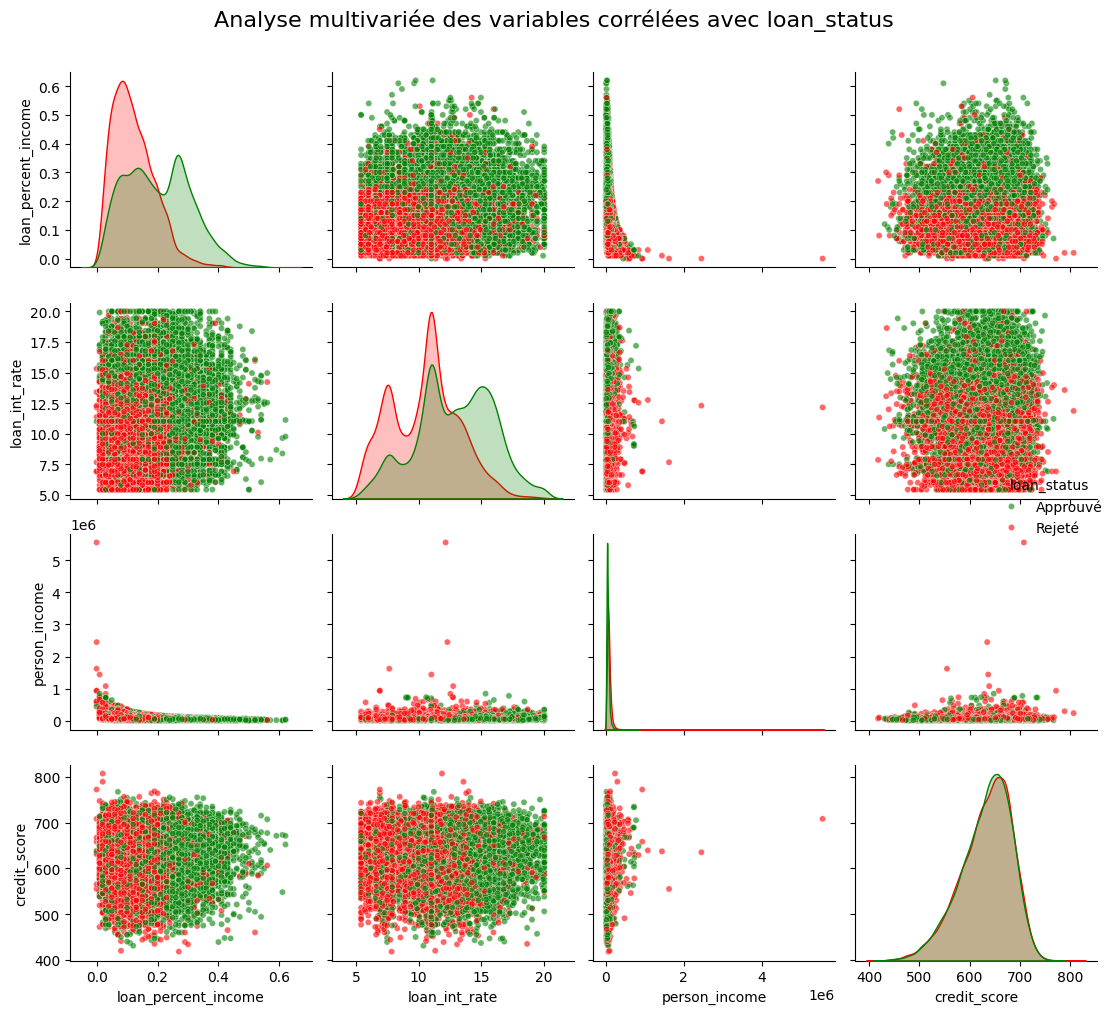


Matrice de corrélation des variables significatives :


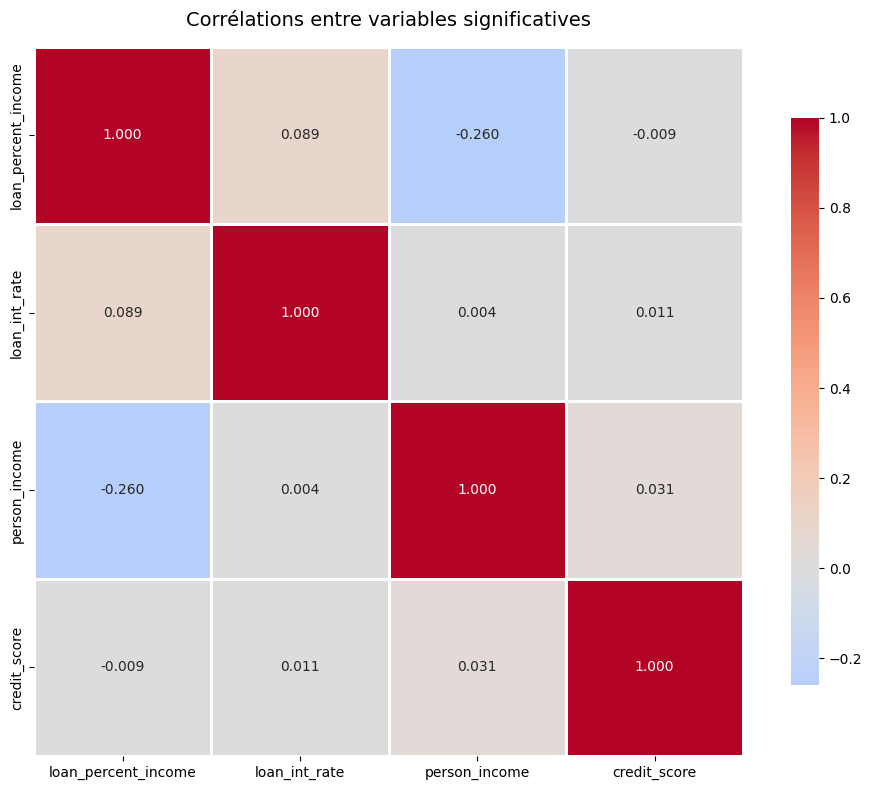

In [10]:
### Analyse détaillée des corrélations significatives

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Variables à analyser en détail
variables_to_analyze = {
    'positive': ['loan_percent_income', 'loan_int_rate'],
    'negative': ['person_income', 'credit_score', 'person_age', 'person_emp_exp']
}


print("ANALYSE APPROFONDIE DES CORRÉLATIONS AVEC LOAN_STATUS")


# PARTIE 1 : CORRÉLATIONS POSITIVES (favorisent l'approbation)

print("\n" + "="*80)
print("1. VARIABLES À CORRÉLATION POSITIVE (plus la valeur augmente, plus l'approbation augmente)")
print("="*80)

for var in variables_to_analyze['positive']:
    corr = df[num_cols].corrwith(df['loan_status'])[var]
    
    print(f"\n{'─'*80}")
    print(f"Variable : {var}")
    print(f"Corrélation avec loan_status : {corr:.3f}")
    
    # Statistiques descriptives par statut
    print("\nStatistiques descriptives par loan_status :")
    stats = df.groupby('loan_status')[var].describe()
    print(stats)
    
    # Test statistique (t-test)
    from scipy.stats import ttest_ind
    group_0 = df[df['loan_status'] == 0][var].dropna()
    group_1 = df[df['loan_status'] == 1][var].dropna()
    t_stat, p_value = ttest_ind(group_0, group_1)
    
    print(f"\nTest de Student (différence de moyennes) :")
    print(f"  • Statistique t : {t_stat:.3f}")
    print(f"  • p-value : {p_value:.4e}")
    print(f"  • Conclusion : {'Différence SIGNIFICATIVE' if p_value < 0.05 else 'Pas de différence significative'}")
    
    # Visualisation
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Boxplot
    ax1 = axes[0]
    df.boxplot(column=var, by='loan_status', ax=ax1)
    ax1.set_title(f'Distribution de {var} par loan_status')
    ax1.set_xlabel('loan_status (0=Rejeté, 1=Approuvé)')
    ax1.set_ylabel(var)
    ax1.get_figure().suptitle('')
    
    # Histogrammes superposés
    ax2 = axes[1]
    df[df['loan_status'] == 0][var].hist(bins=30, alpha=0.5, label='Rejeté (0)', ax=ax2, color='red')
    df[df['loan_status'] == 1][var].hist(bins=30, alpha=0.5, label='Approuvé (1)', ax=ax2, color='green')
    ax2.set_xlabel(var)
    ax2.set_ylabel('Fréquence')
    ax2.set_title(f'Distribution de {var} selon loan_status')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # Scatter plot avec jitter
    ax3 = axes[2]
    jitter = np.random.normal(0, 0.05, size=len(df))
    ax3.scatter(df['loan_status'] + jitter, df[var], alpha=0.3, s=10)
    ax3.set_xlabel('loan_status (0=Rejeté, 1=Approuvé)')
    ax3.set_ylabel(var)
    ax3.set_title(f'{var} vs loan_status (avec jitter)')
    ax3.set_xticks([0, 1])
    ax3.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    


# PARTIE 2 : CORRÉLATIONS NÉGATIVES (défavorisent l'approbation)

print("2. VARIABLES À CORRÉLATION NÉGATIVE (plus la valeur augmente, moins l'approbation augmente)")

for var in variables_to_analyze['negative']:
    corr = df[num_cols].corrwith(df['loan_status'])[var]
    
    print(f"Variable : {var}")
    print(f"Corrélation avec loan_status : {corr:.3f}")
    
    # Statistiques descriptives par statut
    print("\nStatistiques descriptives par loan_status :")
    stats = df.groupby('loan_status')[var].describe()
    print(stats)
    
    # Test statistique (t-test)
    group_0 = df[df['loan_status'] == 0][var].dropna()
    group_1 = df[df['loan_status'] == 1][var].dropna()
    t_stat, p_value = ttest_ind(group_0, group_1)
    
    print(f"\nTest de Student (différence de moyennes) :")
    print(f"  • Statistique t : {t_stat:.3f}")
    print(f"  • p-value : {p_value:.4e}")
    print(f"  • Conclusion : {'Différence SIGNIFICATIVE' if p_value < 0.05 else 'Pas de différence significative'}")
    
    # Visualisation
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Boxplot
    ax1 = axes[0]
    df.boxplot(column=var, by='loan_status', ax=ax1)
    ax1.set_title(f'Distribution de {var} par loan_status')
    ax1.set_xlabel('loan_status (0=Rejeté, 1=Approuvé)')
    ax1.set_ylabel(var)
    ax1.get_figure().suptitle('')
    
    # Histogrammes superposés
    ax2 = axes[1]
    df[df['loan_status'] == 0][var].hist(bins=30, alpha=0.5, label='Rejeté (0)', ax=ax2, color='red')
    df[df['loan_status'] == 1][var].hist(bins=30, alpha=0.5, label='Approuvé (1)', ax=ax2, color='green')
    ax2.set_xlabel(var)
    ax2.set_ylabel('Fréquence')
    ax2.set_title(f'Distribution de {var} selon loan_status')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # Scatter plot avec jitter
    ax3 = axes[2]
    jitter = np.random.normal(0, 0.05, size=len(df))
    ax3.scatter(df['loan_status'] + jitter, df[var], alpha=0.3, s=10)
    ax3.set_xlabel('loan_status (0=Rejeté, 1=Approuvé)')
    ax3.set_ylabel(var)
    ax3.set_title(f'{var} vs loan_status (avec jitter)')
    ax3.set_xticks([0, 1])
    ax3.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    

# PARTIE 3 : ANALYSE MULTIVARIÉE

print("\n\n" + "="*80)
print("3. ANALYSE MULTIVARIÉE : INTERACTIONS ENTRE VARIABLES")

# Pairplot des variables les plus corrélées
significant_vars = ['loan_percent_income', 'loan_int_rate', 'person_income', 'credit_score', 'loan_status']
pairplot_data = df[significant_vars].copy()
pairplot_data['loan_status'] = pairplot_data['loan_status'].map({0: 'Rejeté', 1: 'Approuvé'})

print("\nCréation d'un pairplot des variables significatives...")
g = sns.pairplot(pairplot_data, hue='loan_status', palette={'Rejeté': 'red', 'Approuvé': 'green'}, 
                 diag_kind='kde', plot_kws={'alpha': 0.6, 's': 20})
g.fig.suptitle('Analyse multivariée des variables corrélées avec loan_status', y=1.01, fontsize=16)
plt.tight_layout()
plt.show()

# Matrice de corrélation des variables significatives
print("\nMatrice de corrélation des variables significatives :")
corr_matrix = df[significant_vars[:-1]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Corrélations entre variables significatives', fontsize=14, pad=15)
plt.tight_layout()
plt.show()




🔬 Test du Chi² - Dépendance entre variables catégorielles et loan_status

                      Variable        Chi²       p-value  Cramér V Significatif (α=0.05)
         person_home_ownership 1937.780541  0.000000e+00  0.311270                   OUI
previous_loan_defaults_on_file 9661.821646  0.000000e+00  0.695048                   OUI
                   loan_intent  568.360218 1.384176e-120  0.168576                   OUI
                 person_gender    0.547218  4.594565e-01  0.005231                   NON
              person_education    1.457319  8.341741e-01  0.008536                   NON


 Interprétation des résultats:
• p-value < 0.05 → La variable est DÉPENDANTE de loan_status (corrélation significative)
• p-value ≥ 0.05 → La variable est INDÉPENDANTE de loan_status (pas de lien)
• Cramér's V : intensité de l'association (0 = aucune, 1 = association parfaite)
  - V < 0.1 : négligeable
  - 0.1 ≤ V < 0.3 : faible
  - 0.3 ≤ V < 0.5 : modérée
  - V ≥ 0.5 : forte

 Variable

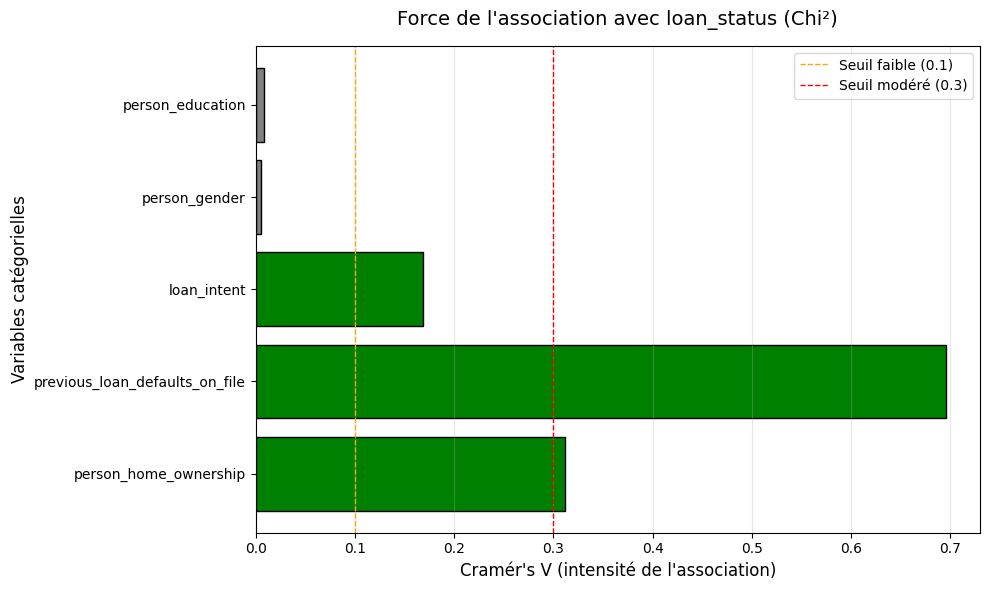

In [11]:
### 3. Test du Chi² pour variables catégorielles

from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

print("\n🔬 Test du Chi² - Dépendance entre variables catégorielles et loan_status")
print("="*80)

# Stocker les résultats
chi2_results = []

# Tester chaque variable catégorielle (sauf loan_status elle-même)
for cat_var in cat_cols:
    if cat_var != 'loan_status':
        # Créer le tableau de contingence
        contingency_table = pd.crosstab(df[cat_var], df['loan_status'])
        
        # Effectuer le test du Chi²
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        
        # Calculer le Cramér's V (mesure d'association normalisée)
        n = contingency_table.sum().sum()
        min_dim = min(contingency_table.shape) - 1
        cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
        
        # Déterminer la significativité
        is_significant = " OUI" if p_value < 0.05 else " NON"
        
        chi2_results.append({
            'Variable': cat_var,
            'Chi²': chi2,
            'p-value': p_value,
            'Cramér V': cramers_v,
            'Significatif (α=0.05)': is_significant
        })

# Créer un DataFrame des résultats
chi2_df = pd.DataFrame(chi2_results).sort_values('p-value')

# Afficher le tableau
print("\n" + chi2_df.to_string(index=False))

# Interprétation détaillée
print("\n\n Interprétation des résultats:")
print("="*80)
print("• p-value < 0.05 → La variable est DÉPENDANTE de loan_status (corrélation significative)")
print("• p-value ≥ 0.05 → La variable est INDÉPENDANTE de loan_status (pas de lien)")
print("• Cramér's V : intensité de l'association (0 = aucune, 1 = association parfaite)")
print("  - V < 0.1 : négligeable")
print("  - 0.1 ≤ V < 0.3 : faible")
print("  - 0.3 ≤ V < 0.5 : modérée")
print("  - V ≥ 0.5 : forte")

# Variables significatives
significant_cats = chi2_df[chi2_df['p-value'] < 0.05]
if len(significant_cats) > 0:
    print(f"\n Variables catégorielles significatives: {len(significant_cats)}/{len(cat_cols)}")
    for _, row in significant_cats.iterrows():
        strength = "forte" if row['Cramér V'] >= 0.5 else "modérée" if row['Cramér V'] >= 0.3 else "faible"
        print(f"  • {row['Variable']}: p={row['p-value']:.4f}, V={row['Cramér V']:.3f} (association {strength})")
else:
    print("\n Aucune variable catégorielle n'est significativement associée à loan_status")

# Visualisation du Cramér's V
plt.figure(figsize=(10, 6))
plt.barh(chi2_df['Variable'], chi2_df['Cramér V'], 
         color=['green' if p < 0.05 else 'gray' for p in chi2_df['p-value']],
         edgecolor='black')
plt.xlabel("Cramér's V (intensité de l'association)", fontsize=12)
plt.ylabel('Variables catégorielles', fontsize=12)
plt.title("Force de l'association avec loan_status (Chi²)", fontsize=14, pad=15)
plt.axvline(x=0.1, color='orange', linestyle='--', linewidth=1, label='Seuil faible (0.1)')
plt.axvline(x=0.3, color='red', linestyle='--', linewidth=1, label='Seuil modéré (0.3)')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

ANALYSE APPROFONDIE DES VARIABLES CATÉGORIELLES AVEC LOAN_STATUS

────────────────────────────────────────────────────────────────────────────────
Variable : person_home_ownership
────────────────────────────────────────────────────────────────────────────────

 Tableau de contingence (effectifs bruts) :
loan_status                0      1    All
person_home_ownership                     
MORTGAGE                4605   2144   6749
OTHER                     28     39     67
OWN                      769    222    991
RENT                    4598   7595  12193
All                    10000  10000  20000

 Répartition de loan_status par modalité (en %) :
loan_status                0      1
person_home_ownership              
MORTGAGE               68.23  31.77
OTHER                  41.79  58.21
OWN                    77.60  22.40
RENT                   37.71  62.29

 Test du Chi² :
  • Statistique χ² : 1937.78
  • Degrés de liberté : 3
  • p-value : 0.0000e+00
  • Cramér's V : 0.311
  • Fo

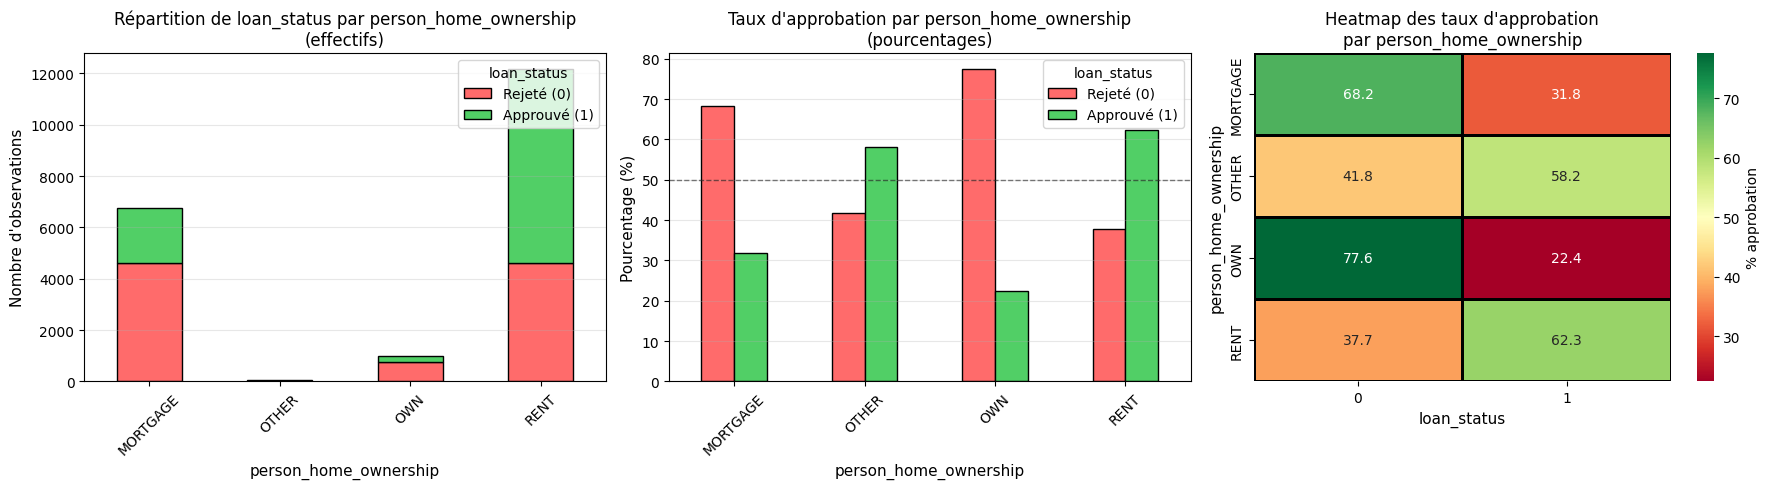


 Analyse détaillée par modalité :
────────────────────────────────────────────────────────────

  RENT :
    • Effectif total : 12193
    • Approuvés : 7595 (62.3%)
    • Rejetés : 4598 (37.7%)
     Taux d'approbation SUPÉRIEUR de 12.3% à la moyenne (50.0%)

  MORTGAGE :
    • Effectif total : 6749
    • Approuvés : 2144 (31.8%)
    • Rejetés : 4605 (68.2%)
     Taux d'approbation INFÉRIEUR de 18.2% à la moyenne (50.0%)

  OWN :
    • Effectif total : 991
    • Approuvés : 222 (22.4%)
    • Rejetés : 769 (77.6%)
     Taux d'approbation INFÉRIEUR de 27.6% à la moyenne (50.0%)

  OTHER :
    • Effectif total : 67
    • Approuvés : 39 (58.2%)
    • Rejetés : 28 (41.8%)
     Taux d'approbation SUPÉRIEUR de 8.2% à la moyenne (50.0%)

────────────────────────────────────────────────────────────────────────────────
Variable : previous_loan_defaults_on_file
────────────────────────────────────────────────────────────────────────────────

 Tableau de contingence (effectifs bruts) :
loan_status

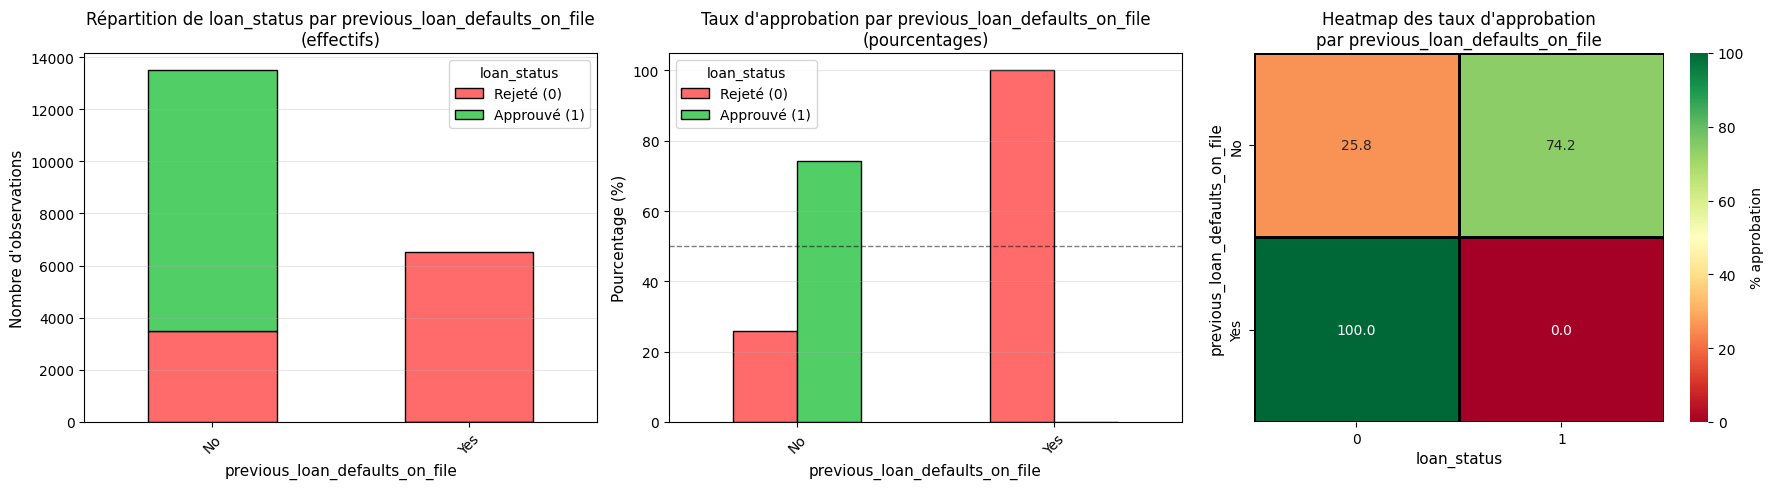


 Analyse détaillée par modalité :
────────────────────────────────────────────────────────────

  No :
    • Effectif total : 13484
    • Approuvés : 10000 (74.2%)
    • Rejetés : 3484 (25.8%)
     Taux d'approbation SUPÉRIEUR de 24.2% à la moyenne (50.0%)

  Yes :
    • Effectif total : 6516
    • Approuvés : 0 (0.0%)
    • Rejetés : 6516 (100.0%)
     Taux d'approbation INFÉRIEUR de 50.0% à la moyenne (50.0%)

────────────────────────────────────────────────────────────────────────────────
Variable : loan_intent
────────────────────────────────────────────────────────────────────────────────

 Tableau de contingence (effectifs bruts) :
loan_status            0      1    All
loan_intent                           
DEBTCONSOLIDATION   1483   2163   3646
EDUCATION           2188   1552   3740
HOMEIMPROVEMENT     1002   1258   2260
MEDICAL             1725   2378   4103
PERSONAL            1722   1521   3243
VENTURE             1880   1128   3008
All                10000  10000  20000

 

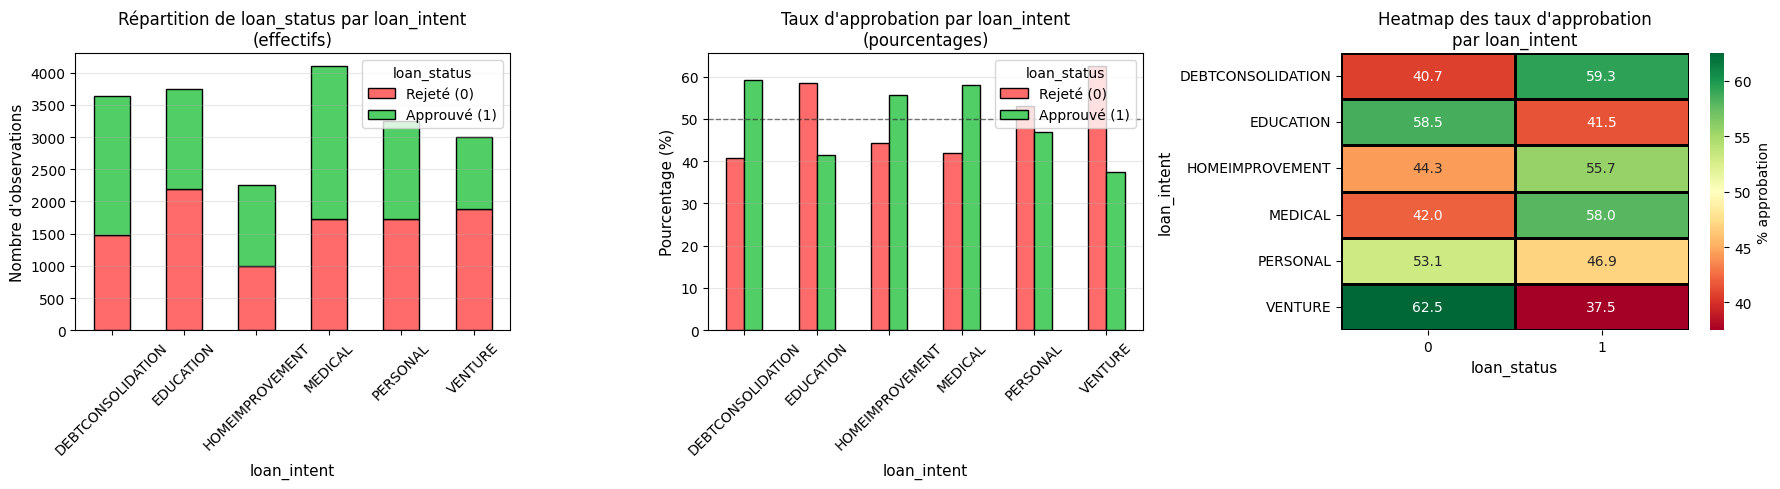


 Analyse détaillée par modalité :
────────────────────────────────────────────────────────────

  DEBTCONSOLIDATION :
    • Effectif total : 3646
    • Approuvés : 2163 (59.3%)
    • Rejetés : 1483 (40.7%)
     Taux d'approbation SUPÉRIEUR de 9.3% à la moyenne (50.0%)

  VENTURE :
    • Effectif total : 3008
    • Approuvés : 1128 (37.5%)
    • Rejetés : 1880 (62.5%)
     Taux d'approbation INFÉRIEUR de 12.5% à la moyenne (50.0%)

  EDUCATION :
    • Effectif total : 3740
    • Approuvés : 1552 (41.5%)
    • Rejetés : 2188 (58.5%)
     Taux d'approbation INFÉRIEUR de 8.5% à la moyenne (50.0%)

  MEDICAL :
    • Effectif total : 4103
    • Approuvés : 2378 (58.0%)
    • Rejetés : 1725 (42.0%)
     Taux d'approbation SUPÉRIEUR de 8.0% à la moyenne (50.0%)

  HOMEIMPROVEMENT :
    • Effectif total : 2260
    • Approuvés : 1258 (55.7%)
    • Rejetés : 1002 (44.3%)
     Taux d'approbation SUPÉRIEUR de 5.7% à la moyenne (50.0%)

  PERSONAL :
    • Effectif total : 3243
    • Approuvés : 152

In [12]:
### Analyse détaillée des variables catégorielles significatives

from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Variables catégorielles significatives identifiées
significant_categorical_vars = ['person_home_ownership', 'previous_loan_defaults_on_file', 'loan_intent']

print("="*80)
print("ANALYSE APPROFONDIE DES VARIABLES CATÉGORIELLES AVEC LOAN_STATUS")
print("="*80)

for cat_var in significant_categorical_vars:
    print(f"\n{'─'*80}")
    print(f"Variable : {cat_var}")
    print(f"{'─'*80}")
    
    # 1. Tableau de contingence
    contingency_table = pd.crosstab(df[cat_var], df['loan_status'], margins=True)
    print("\n Tableau de contingence (effectifs bruts) :")
    print(contingency_table)
    
    # 2. Tableau en pourcentages (par ligne = par modalité)
    contingency_pct = pd.crosstab(df[cat_var], df['loan_status'], normalize='index') * 100
    print("\n Répartition de loan_status par modalité (en %) :")
    print(contingency_pct.round(2))
    
    # 3. Test du Chi²
    contingency_no_margins = pd.crosstab(df[cat_var], df['loan_status'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_no_margins)
    
    # Calcul du Cramér's V
    n = contingency_no_margins.sum().sum()
    min_dim = min(contingency_no_margins.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
    
    print(f"\n Test du Chi² :")
    print(f"  • Statistique χ² : {chi2:.2f}")
    print(f"  • Degrés de liberté : {dof}")
    print(f"  • p-value : {p_value:.4e}")
    print(f"  • Cramér's V : {cramers_v:.3f}")
    
    # Interprétation de la force
    if cramers_v >= 0.5:
        strength = "FORTE"
    elif cramers_v >= 0.3:
        strength = "MODÉRÉE"
    elif cramers_v >= 0.1:
        strength = "FAIBLE"
    else:
        strength = "NÉGLIGEABLE"
    
    print(f"  • Force de l'association : {strength}")
    print(f"  • Conclusion : {'Association SIGNIFICATIVE' if p_value < 0.05 else 'Pas d association significative'}")
    
    # 4. Visualisations
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 4.1. Graphique en barres empilées (effectifs)
    ax1 = axes[0]
    contingency_no_margins.plot(kind='bar', stacked=True, ax=ax1, 
                                color=['#ff6b6b', '#51cf66'], edgecolor='black')
    ax1.set_title(f'Répartition de loan_status par {cat_var}\n(effectifs)', fontsize=12)
    ax1.set_xlabel(cat_var, fontsize=11)
    ax1.set_ylabel('Nombre d\'observations', fontsize=11)
    ax1.legend(title='loan_status', labels=['Rejeté (0)', 'Approuvé (1)'], loc='upper right')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # 4.2. Graphique en barres groupées (pourcentages)
    ax2 = axes[1]
    contingency_pct.plot(kind='bar', ax=ax2, color=['#ff6b6b', '#51cf66'], edgecolor='black')
    ax2.set_title(f'Taux d\'approbation par {cat_var}\n(pourcentages)', fontsize=12)
    ax2.set_xlabel(cat_var, fontsize=11)
    ax2.set_ylabel('Pourcentage (%)', fontsize=11)
    ax2.legend(title='loan_status', labels=['Rejeté (0)', 'Approuvé (1)'], loc='best')
    ax2.tick_params(axis='x', rotation=45)
    ax2.axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax2.grid(axis='y', alpha=0.3)
    
    # 4.3. Heatmap du tableau de contingence normalisé
    ax3 = axes[2]
    sns.heatmap(contingency_pct, annot=True, fmt='.1f', cmap='RdYlGn', 
                center=50, ax=ax3, cbar_kws={'label': '% approbation'},
                linewidths=1, linecolor='black')
    ax3.set_title(f'Heatmap des taux d\'approbation\npar {cat_var}', fontsize=12)
    ax3.set_xlabel('loan_status', fontsize=11)
    ax3.set_ylabel(cat_var, fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # 5. Analyse détaillée par modalité
    print(f"\n Analyse détaillée par modalité :")
    print(f"{'─'*60}")
    
    for modality in df[cat_var].unique():
        subset = df[df[cat_var] == modality]
        approval_rate = (subset['loan_status'] == 1).mean() * 100
        n_obs = len(subset)
        n_approved = (subset['loan_status'] == 1).sum()
        n_rejected = (subset['loan_status'] == 0).sum()
        
        print(f"\n  {modality} :")
        print(f"    • Effectif total : {n_obs}")
        print(f"    • Approuvés : {n_approved} ({approval_rate:.1f}%)")
        print(f"    • Rejetés : {n_rejected} ({100-approval_rate:.1f}%)")
        
        # Comparaison avec la moyenne globale
        global_approval_rate = (df['loan_status'] == 1).mean() * 100
        diff = approval_rate - global_approval_rate
        
        if abs(diff) > 5:  # Seuil de 5% de différence
            if diff > 0:
                print(f"     Taux d'approbation SUPÉRIEUR de {diff:.1f}% à la moyenne ({global_approval_rate:.1f}%)")
            else:
                print(f"     Taux d'approbation INFÉRIEUR de {abs(diff):.1f}% à la moyenne ({global_approval_rate:.1f}%)")
        else:
            print(f"    ✓ Taux d'approbation proche de la moyenne ({global_approval_rate:.1f}%)")
    


In [13]:
# Prétraitement général: imputation/scale/OHE via ColumnTransformer
# construire X et y en incluant les colonnes clean
cols_keep = [c for c in df.columns if c != 'loan_status']
X = df[cols_keep].copy()
y = df['loan_status'].copy()


# Séparation des données numériques et catégorielles
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]
print('num_cols:', num_cols)
print('cat_cols:', cat_cols)

numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([('num', numeric_transformer, num_cols), ('cat', categorical_transformer, cat_cols)])

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train/Test shapes:', X_train.shape, X_test.shape)

num_cols: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']
cat_cols: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Train/Test shapes: (16000, 13) (4000, 13)


# Modèles

## Introduction des données d'entraînement et d'évaluation

Les variables globales d'entraînement et d'évaluation sont :
* X_train, y_train
* X_test, y_test

## Dernière visualisation des données


In [14]:
Visualiser = X_train.copy()
Visualiser ['label_loan_status'] = y_train
Visualiser.head()

person_age person_gender person_education  person_income  \
7017           24          male      High School        16470.0   
9135           22        female         Bachelor        72916.0   
10090          26        female         Bachelor        90805.0   
3614           23          male        Associate        30034.0   
19922          47          male           Master        46967.0   

       person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
7017                2              MORTGAGE     4500.0  DEBTCONSOLIDATION   
9135                0                  RENT     2000.0          EDUCATION   
10090               4                  RENT    20000.0          EDUCATION   
3614                2                  RENT     2700.0  DEBTCONSOLIDATION   
19922              27                  RENT    22000.0            MEDICAL   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
7017           11.83                 0.27                         4.0   
9135            9.63                 0.03                         2.0   
10090          11.01                 0.22                         3.0   
3614           10.75                 0.09                         2.0   
19922          18.78                 0.47                        17.0   

       credit_score previous_loan_defaults_on_file  label_loan_status  
7017            643                             No                  1  
9135            619                            Yes                  0  
10090           603                             No                  0  
3614            599                             No                  1  
19922           661                             No                  1

## Fonctions d'accélération

In [15]:
def save_model(model):
    """
    Sauvegarde un modèle au format joblib avec le nom de la variable globale.
    
    Args:
        model: Le modèle à sauvegarder.
    """
    model_name = None
    for name, obj in globals().items():
        if obj is model:
            model_name = name
            break
    if model_name is None:
        model_name = "unknown_model"
    filename = f"{model_name}.joblib"
    joblib.dump(model, filename)
    print(f"Modèle sauvegardé sous : {filename}")


def load_model(model_name):
    """
    Charge un modèle depuis un fichier joblib.
    
    Args:
        model_name (str): Le nom du fichier (sans extension .joblib).
    
    Returns:
        Le modèle chargé si le fichier existe, sinon False.
    """
    filename = f"{model_name}.joblib"
    if os.path.exists(filename):
        model = joblib.load(filename)
        print(f"Modèle chargé depuis : {filename}")
        return model
    else:
        print(f"Fichier {filename} non trouvé.")
        return False

## 1. Modèles Linéraires

### Logisitic Regression

Quelques commentaires : le C apparait dans la fonction coût, le modèle réalise ici une régression linéaire classique et utilise la fonction sigmoïde pour limiter les résultats à la plage [0;1], le seuil de classification est de 0.5.


In [16]:
pipe = Pipeline([('preprocessor', preprocessor), 
                 ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))])
param_grid = {'clf__C': [0.01, 0.1, 1.0, 10.0, 100.0, 200.0, 400.0, 700.0, 1000.0]}
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)
print('Best params:', gs.best_params_)
best_lr = gs.best_estimator_

# évaluer sur test
y_pred = best_lr.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification report:\n', classification_report(y_test, y_pred))

Best params: {'clf__C': 400.0}
Test accuracy: 0.87275

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.84      0.87      2000
           1       0.85      0.91      0.88      2000

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000



#### Observation des CV de chaque C

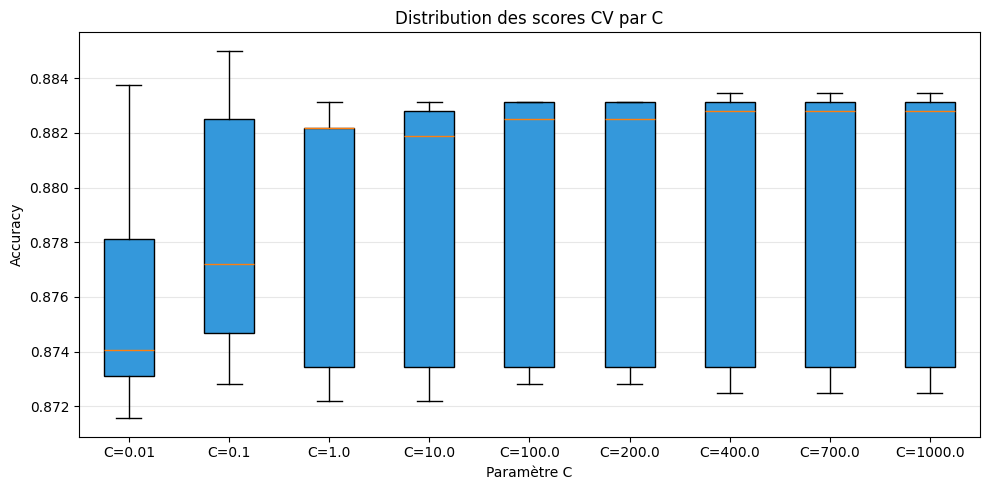

LOGISTIC REGRESSION - GRIDSEARCH CV RESULTS
Paramètres testés: C = [np.float64(0.01), np.float64(0.1), np.float64(1.0), np.float64(10.0), np.float64(100.0), np.float64(200.0), np.float64(400.0), np.float64(700.0), np.float64(1000.0)]

C          Mean       Std        Min        Max       
----------------------------------------------------------------------
0.01       0.8761     0.0044     0.8716     0.8838    
0.10       0.8784     0.0046     0.8728     0.8850    
1.00       0.8786     0.0048     0.8722     0.8831    
10.00      0.8787     0.0048     0.8722     0.8831    
100.00     0.8790     0.0048     0.8728     0.8831    
200.00     0.8790     0.0048     0.8728     0.8831    
400.00     0.8791     0.0050     0.8725     0.8834    
700.00     0.8791     0.0050     0.8725     0.8834    
1000.00    0.8791     0.0050     0.8725     0.8834    


In [17]:
cv_results_lr = pd.DataFrame(gs.cv_results_)
c_values = sorted(cv_results_lr['param_clf__C'].unique())

# Box plot comparatif
fig, ax = plt.subplots(figsize=(10, 5))
data_to_plot = [[cv_results_lr[cv_results_lr['param_clf__C'] == c].iloc[0][f'split{i}_test_score'] 
                  for i in range(5)] for c in c_values]
bp = ax.boxplot(data_to_plot, labels=[f'C={c}' for c in c_values], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('#3498db')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Paramètre C')
ax.set_title('Distribution des scores CV par C')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Tableau récapitulatif
print("LOGISTIC REGRESSION - GRIDSEARCH CV RESULTS")
print("="*70)
print(f"Paramètres testés: C = {c_values}")
print(f"\n{'C':<10} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
print("-"*70)
for c_val in c_values:
    row = cv_results_lr[cv_results_lr['param_clf__C'] == c_val].iloc[0]
    fold_scores = [row[f'split{i}_test_score'] for i in range(5)]
    print(f"{c_val:<10.2f} {row['mean_test_score']:<10.4f} {row['std_test_score']:<10.4f} "
          f"{min(fold_scores):<10.4f} {max(fold_scores):<10.4f}")

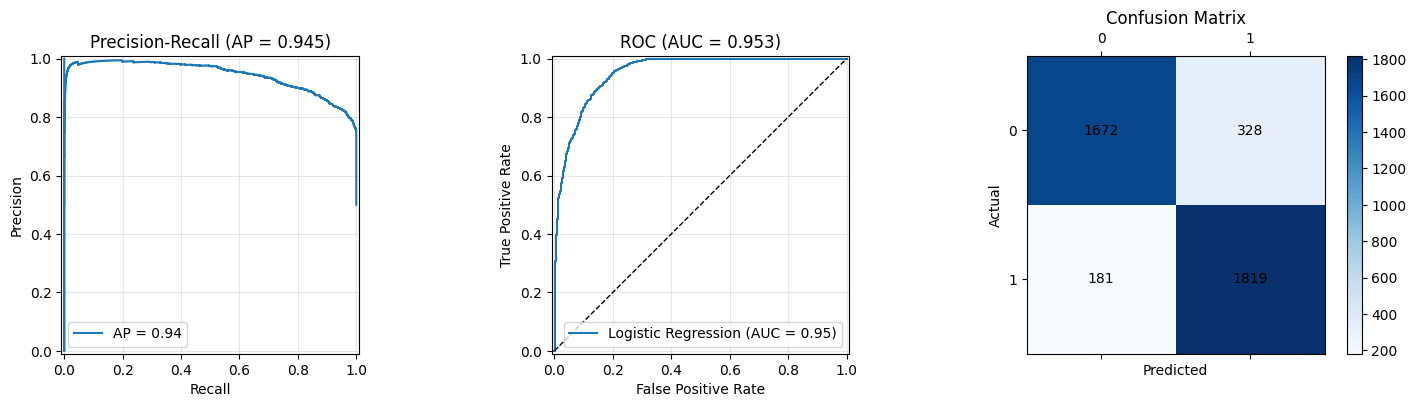

In [18]:
from sklearn.metrics import (
    precision_recall_curve, average_precision_score, PrecisionRecallDisplay,
    roc_curve, roc_auc_score, RocCurveDisplay,
    confusion_matrix
)

# Calculer les probabilités prédites
y_proba = best_lr.predict_proba(X_test)[:, 1]

# Créer les 3 graphiques
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Courbe Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
display_pr = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap)
display_pr.plot(ax=axes[0])
axes[0].set_title(f'Precision-Recall (AP = {ap:.3f})')
axes[0].grid(alpha=0.3)

# 2. Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
display_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display_roc.plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_title(f'ROC (AUC = {roc_auc:.3f})')
axes[1].grid(alpha=0.3)

# 3. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
cax = axes[2].matshow(cm, cmap='Blues')
for (i, j), val in np.ndenumerate(cm):
    axes[2].text(j, i, int(val), ha='center', va='center', color='black')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_title('Confusion Matrix')
fig.colorbar(cax, ax=axes[2])

plt.tight_layout()
plt.show()

## Modélisation pour Random Forest : preprocessing et gridsearch

* Le nombre de cas possible étant trop grand, l'entrainement du modèle avec un algorithme d'optimisation glouton est trop lent, on teste donc deux autres méthodes : RandomizedSeachCV et HalvingGridSearchCV pour random forest et extra tree classifier

## Random Forest

Random Forest est un algorithme d'ensemble basé sur la méthode des arbres de décision. Il construit plusieurs arbres de décision indépendants sur des sous-échantillons bootstrap du jeu de données d'entraînement, puis agrège leurs prédictions par vote majoritaire pour la classification. Chaque arbre est entraîné sur un sous-ensemble aléatoire des features pour introduire de la diversité.

**Formule de prédiction pour la classification :**

$$
\hat{y} = \arg\max_k \sum_{t=1}^T I(\hat{y}^{(t)} = k)
$$

où $T$ est le nombre d'arbres, $\hat{y}^{(t)}$ est la prédiction du $t$-ième arbre pour la classe $k$, et $I$ est la fonction indicatrice.

**Critère de division (Gini) :**

$$
\text{Gini} = 1 - \sum_{k=1}^K p_k^2
$$

où $p_k$ est la proportion d'échantillons de classe $k$ dans le nœud.

**Réduction de variance :**

$$
\text{Var}(\hat{y}) = \frac{1}{T} \text{Var}(\hat{y}^{(t)}) + \frac{T-1}{T} \text{Cov}(\hat{y}^{(t)}, \hat{y}^{(t')})
$$

L'agrégation réduit la variance tout en maintenant un faible biais.

In [19]:
# from sklearn.ensemble import RandomForestClassifier

# # Pipeline avec RandomForest
# pipe_rf = Pipeline([
#     ('preprocessor', preprocessor), 
#     ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
# ])

# # GridSearch pour RandomForest
# param_grid_rf = {
#     'clf__n_estimators': [600, 700, 900],
#     'clf__max_depth': [10, 20, 50, 70],
#     'clf__min_samples_split': [2, 5, 7, 8]
# }

# gs_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1, verbose=1)
# gs_rf.fit(X_train, y_train)

# print('Best params:', gs_rf.best_params_)
# best_rf = gs_rf.best_estimator_

# # Évaluation sur test
# y_pred_rf = best_rf.predict(X_test)
# print('Test accuracy:', accuracy_score(y_test, y_pred_rf))
# print('\nClassification report:\n', classification_report(y_test, y_pred_rf))

In [20]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

pipe_rf = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

param_dist_rf = {
    'clf__n_estimators': [300, 500],
    'clf__max_depth': [10, 20, 30, 50, 70],
    'clf__min_samples_split': [2, 3, 5, 7, 8],
}

rs_rf = RandomizedSearchCV(
    pipe_rf, 
    param_distributions=param_dist_rf,
    n_iter=50, 
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)


rs_rf.fit(X_train, y_train)

print('\nMeilleurs paramètres (RandomizedSearchCV):', rs_rf.best_params_)
print(f'Meilleur F1-score (CV): {rs_rf.best_score_:.4f}')
print(f'Nombre total de fits: {len(rs_rf.cv_results_["param_clf__n_estimators"]) * 5} (50 × 5 folds)')

best_rf = rs_rf.best_estimator_
save_model(best_rf)

y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

print(f'\nMétriques test:')
print(f'Accuracy : {accuracy_score(y_test, y_pred_rf):.4f}')
print(f'F1-score : {f1_score(y_test, y_pred_rf):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_rf):.4f}')
print(f'Recall   : {recall_score(y_test, y_pred_rf):.4f}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Meilleurs paramètres (RandomizedSearchCV): {'clf__n_estimators': 500, 'clf__min_samples_split': 7, 'clf__max_depth': 20}
Meilleur F1-score (CV): 0.9039
Nombre total de fits: 250 (50 × 5 folds)
Modèle sauvegardé sous : best_rf.joblib

Métriques test:
Accuracy : 0.8968
F1-score : 0.8992
Precision: 0.8780
Recall   : 0.9215


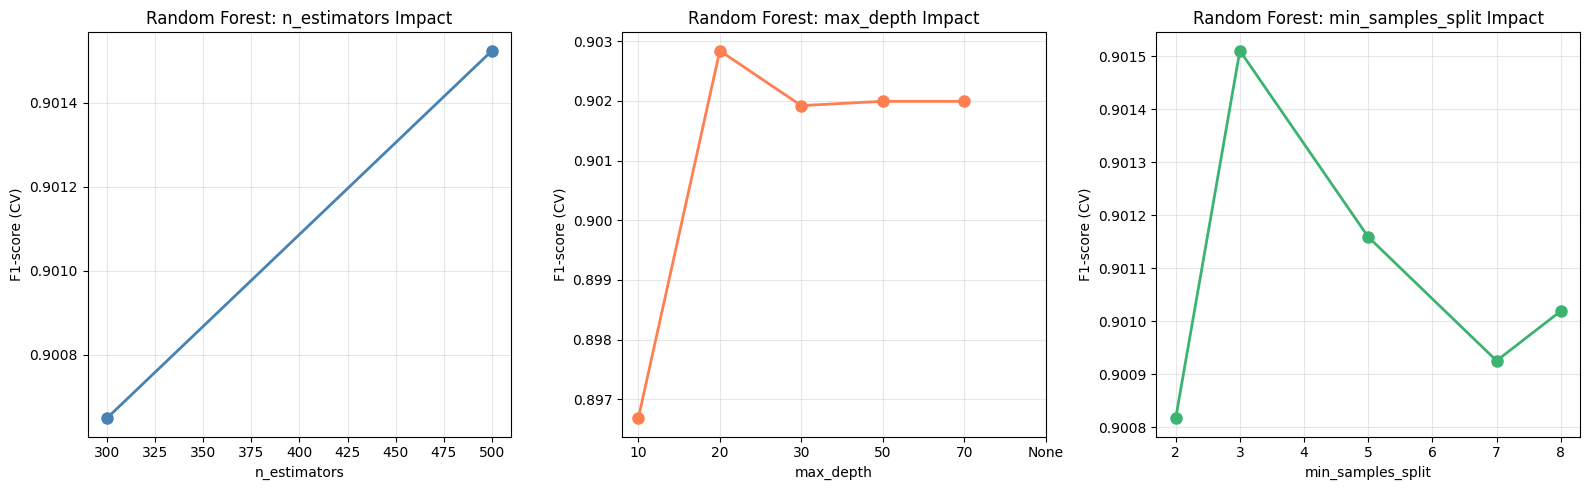

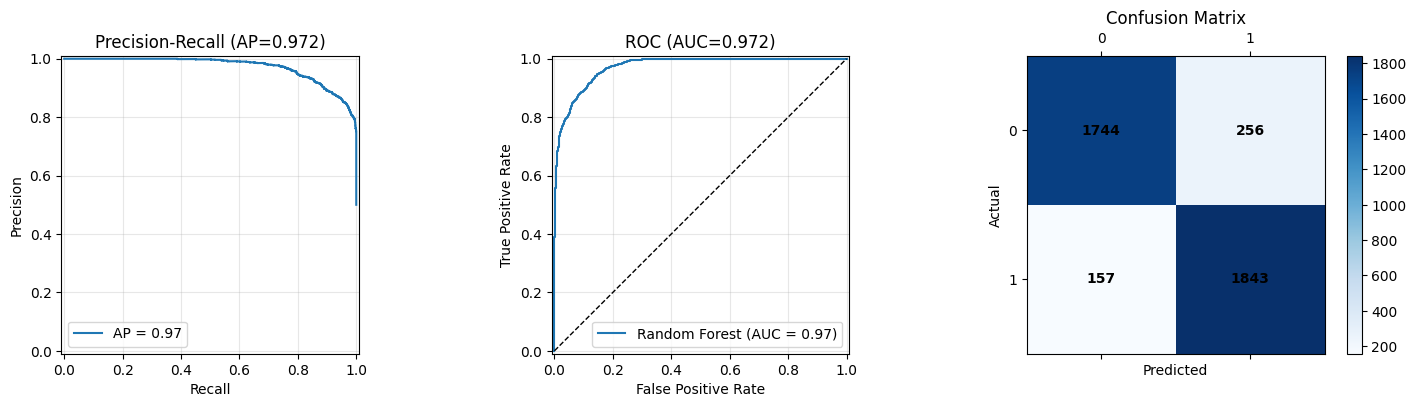

In [21]:
cv_results_rf = pd.DataFrame(rs_rf.cv_results_)

n_ests = sorted(cv_results_rf['param_clf__n_estimators'].unique())
max_depths = sorted([x for x in cv_results_rf['param_clf__max_depth'].unique() if x is not None]) + [None]
min_splits = sorted(cv_results_rf['param_clf__min_samples_split'].unique())

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

ax1 = axes[0]
means_n = []
for n_est in n_ests:
    mask = cv_results_rf['param_clf__n_estimators'] == n_est
    data = cv_results_rf[mask]['mean_test_score'].values
    means_n.append(data.mean())

ax1.plot(n_ests, means_n, 'o-', linewidth=2, markersize=8, color='steelblue')
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('F1-score (CV)')
ax1.set_title('Random Forest: n_estimators Impact')
ax1.grid(alpha=0.3)

ax2 = axes[1]
means_d = []
depth_labels = []
for max_depth in max_depths:
    mask = cv_results_rf['param_clf__max_depth'] == max_depth
    data = cv_results_rf[mask]['mean_test_score'].values
    means_d.append(data.mean())
    depth_labels.append(str(max_depth) if max_depth is not None else 'None')

x_pos = range(len(max_depths))
ax2.plot(x_pos, means_d, 'o-', linewidth=2, markersize=8, color='coral')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(depth_labels)
ax2.set_xlabel('max_depth')
ax2.set_ylabel('F1-score (CV)')
ax2.set_title('Random Forest: max_depth Impact')
ax2.grid(alpha=0.3)

ax3 = axes[2]
means_m = []
for min_split in min_splits:
    mask = cv_results_rf['param_clf__min_samples_split'] == min_split
    data = cv_results_rf[mask]['mean_test_score'].values
    means_m.append(data.mean())

ax3.plot(min_splits, means_m, 'o-', linewidth=2, markersize=8, color='mediumseagreen')
ax3.set_xlabel('min_samples_split')
ax3.set_ylabel('F1-score (CV)')
ax3.set_title('Random Forest: min_samples_split Impact')
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

precision, recall, _ = precision_recall_curve(y_test, y_proba_rf)
ap = average_precision_score(y_test, y_proba_rf)
display_pr = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap)
display_pr.plot(ax=axes[0])
axes[0].set_title(f'Precision-Recall (AP={ap:.3f})')
axes[0].grid(alpha=0.3)

fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
roc_auc = roc_auc_score(y_test, y_proba_rf)
display_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest')
display_roc.plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_title(f'ROC (AUC={roc_auc:.3f})')
axes[1].grid(alpha=0.3)

cm_rf = confusion_matrix(y_test, y_pred_rf)
cax = axes[2].matshow(cm_rf, cmap='Blues')
for (i, j), val in np.ndenumerate(cm_rf):
    axes[2].text(j, i, int(val), ha='center', va='center', color='black', fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_title('Confusion Matrix')
fig.colorbar(cax, ax=axes[2])

plt.tight_layout()
plt.show()

## Modélisation pour ExtraTreesClassifier

## Extra Trees (Extremely Randomized Trees)

Extra Trees est une variante de Random Forest qui introduit plus de randomisation dans la construction des arbres. Contrairement à Random Forest, les seuils de division sont choisis aléatoirement plutôt que de manière optimale, ce qui accélère l'entraînement et réduit le surapprentissage.

**Formule de prédiction :**

$$
\hat{y} = \arg\max_k \sum_{i=1}^T I(\hat{y}_i^{(t)} = k)
$$

Identique à Random Forest, utilisant le vote majoritaire des $T$ arbres.

**Critère de division :**

Au lieu d'optimiser le critère de Gini ou d'entropie, les seuils sont tirés uniformément dans l'intervalle des valeurs des features :

$$
\text{threshold} \sim \mathcal{U}(\min(X_j), \max(X_j))
$$

où $X_j$ est la $j$-ième feature.

**Avantage mathématique :**

La randomisation accrue conduit à une variance plus faible :

$$
\text{Var}(\text{ET}) < \text{Var}(\text{RF})
$$

en raison de l'indépendance plus forte entre les arbres.

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 500
max_resources_: 16000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 40
n_resources: 500
Fitting 5 folds for each of 40 candidates, totalling 200 fits
----------
iter: 1
n_candidates: 20
n_resources: 1000
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 2
n_candidates: 10
n_resources: 2000
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 3
n_candidates: 5
n_resources: 4000
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 3
n_resources: 8000
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 5
n_candidates: 2
n_resources: 16000
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params: {'clf__max_depth': 20, 'clf__min_samples_split': 7, 'clf__n_estimators': 500}
Test accuracy: 0.884
Test F1-score: 0.889943074003795
Test Precision: 0.846

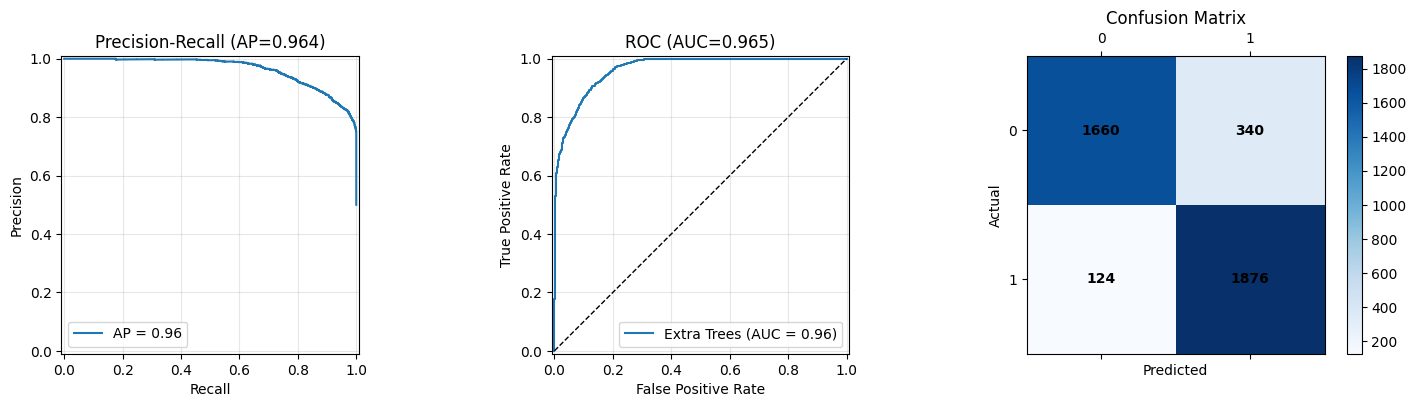

In [22]:
from sklearn.experimental import enable_halving_search_cv  # Active la fonctionnalité expérimentale
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import ExtraTreesClassifier

pipe_etc = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', ExtraTreesClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

param_grid_etc = {
    'clf__n_estimators': [300, 500],
    'clf__max_depth': [10, 20, 50, 70, 90],
    'clf__min_samples_split': [2, 5, 7, 10]
}

hgs_etc = HalvingGridSearchCV(
    pipe_etc,
    param_grid=param_grid_etc,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    factor=2,
    random_state=42
)

hgs_etc.fit(X_train, y_train)

print('Best params:', hgs_etc.best_params_)
best_etc = hgs_etc.best_estimator_

y_pred_etc = best_etc.predict(X_test)
y_proba_etc = best_etc.predict_proba(X_test)[:, 1]

print('Test accuracy:', accuracy_score(y_test, y_pred_etc))
print('Test F1-score:', f1_score(y_test, y_pred_etc))
print('Test Precision:', precision_score(y_test, y_pred_etc))
print('Test Recall:', recall_score(y_test, y_pred_etc))
print('\nClassification report:\n', classification_report(y_test, y_pred_etc))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

precision, recall, _ = precision_recall_curve(y_test, y_proba_etc)
ap = average_precision_score(y_test, y_proba_etc)
display_pr = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap)
display_pr.plot(ax=axes[0])
axes[0].set_title(f'Precision-Recall (AP={ap:.3f})')
axes[0].grid(alpha=0.3)

fpr, tpr, _ = roc_curve(y_test, y_proba_etc)
roc_auc = roc_auc_score(y_test, y_proba_etc)
display_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Extra Trees')
display_roc.plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_title(f'ROC (AUC={roc_auc:.3f})')
axes[1].grid(alpha=0.3)

cm_etc = confusion_matrix(y_test, y_pred_etc)
cax = axes[2].matshow(cm_etc, cmap='Blues')
for (i, j), val in np.ndenumerate(cm_etc):
    axes[2].text(j, i, int(val), ha='center', va='center', color='black', fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_title('Confusion Matrix')
fig.colorbar(cax, ax=axes[2])

plt.tight_layout()
plt.show()

Top 20 features les plus importantes (ExtraTreesClassifier) :
                                feature  importance
cat__previous_loan_defaults_on_file_Yes    0.286746
 cat__previous_loan_defaults_on_file_No    0.285465
                     num__loan_int_rate    0.081939
               num__loan_percent_income    0.072547
        cat__person_home_ownership_RENT    0.046773
                     num__person_income    0.038482
    cat__person_home_ownership_MORTGAGE    0.028078
                         num__loan_amnt    0.024764
                      num__credit_score    0.019137
                        num__person_age    0.013773
        num__cb_person_cred_hist_length    0.013065
                    num__person_emp_exp    0.012925
               cat__loan_intent_VENTURE    0.009047
         cat__person_home_ownership_OWN    0.008148
     cat__loan_intent_DEBTCONSOLIDATION    0.006876
               cat__loan_intent_MEDICAL    0.006600
             cat__loan_intent_EDUCATION    0.005819
  

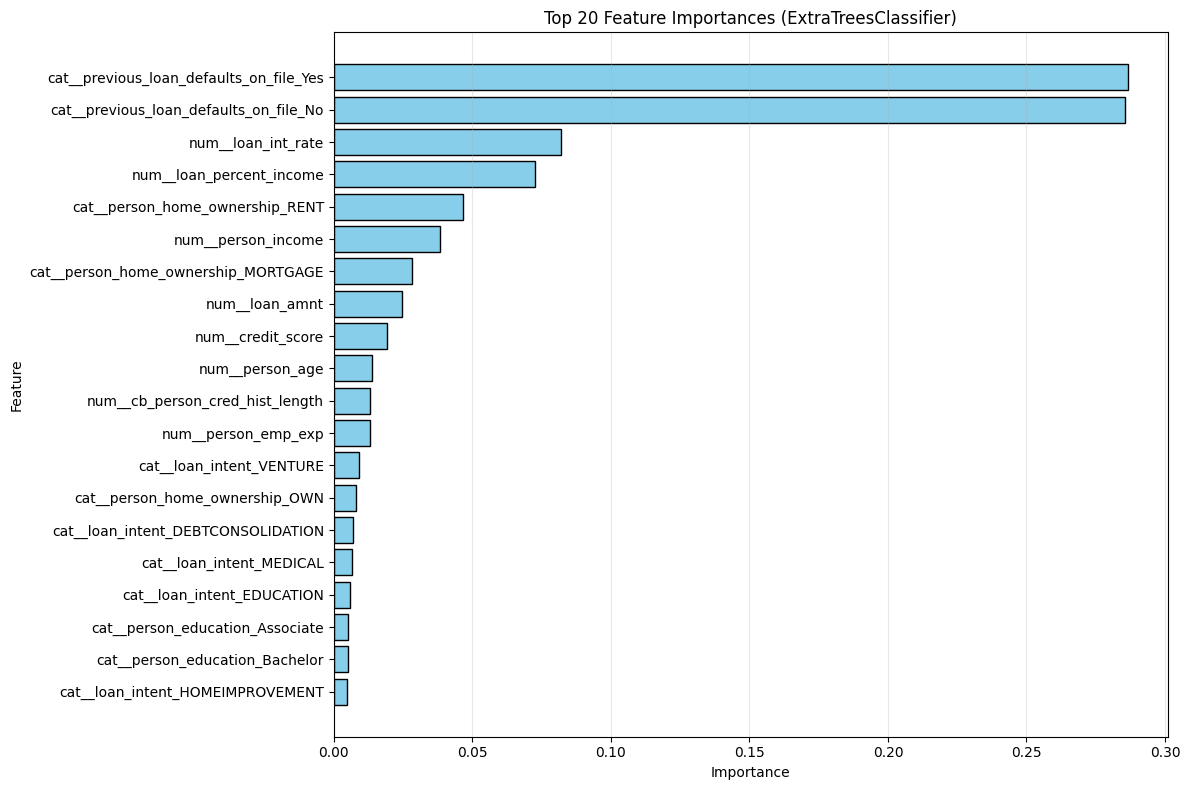

In [23]:
# Importance des features pour ExtraTreesClassifier

# Obtenir les noms des features après transformation (utiliser le preprocessor du modèle entraîné)
feature_names = best_etc.named_steps['preprocessor'].get_feature_names_out()

# Obtenir les importances des features
feature_importances = best_etc.named_steps['clf'].feature_importances_

# Créer un DataFrame pour faciliter le tri et la visualisation
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# Afficher les 20 features les plus importantes
print("Top 20 features les plus importantes (ExtraTreesClassifier) :")
print(importance_df.head(20).to_string(index=False))

# Graphique des importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['feature'][:20], importance_df['importance'][:20], color='skyblue', edgecolor='black')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances (ExtraTreesClassifier)')
plt.gca().invert_yaxis()  # Inverser pour avoir la plus importante en haut
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Pipeline avec LightGBM

## LightGBM (Light Gradient Boosting Machine)

LightGBM est un algorithme de boosting basé sur les arbres de décision qui utilise une approche de croissance **leaf-wise (par feuille)** plutôt que level-wise, permettant une meilleure précision avec moins de calcul. Il emploie des techniques d'échantillonnage (**GOSS** et **EFB**) pour gérer les grands jeux de données efficacement.

**Formule de boosting :**

$$
F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)
$$

où $F_m(x)$ est le modèle à l'itération $m$, $\eta$ est le taux d'apprentissage, et $h_m(x)$ est l'arbre faible.

**Fonction de perte :**

$$
\mathcal{L}(F) = \sum_{i=1}^n l(y_i, F(x_i)) + \Omega(F)
$$

où $l$ est la perte (ex. : log-loss pour classification), et $\Omega(F)$ est un terme de régularisation.

**Gradient One-Side Sampling (GOSS) :**

Sélectionne les échantillons avec les gradients les plus grands et un sous-échantillon aléatoire des petits gradients pour approximer la distribution :

$$
\tilde{\mathcal{D}} = \mathcal{D}_{\text{large}} \cup \mathcal{D}_{\text{small}}^{\text{sampled}}
$$

**Exclusive Feature Bundling (EFB) :**

Regroupe les features mutuellement exclusives pour réduire la dimensionalité :

$$
\text{Bundle}(f_1, f_2) = \arg\min_{c} \sum_{i} |f_1^i - f_2^i - c|
$$


In [24]:
from lightgbm import LGBMClassifier

# Pipeline avec LightGBM (pas besoin de libomp !)
pipe_lgbm = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', LGBMClassifier(random_state=42, verbose=-1, n_jobs=1))
])

# GridSearch pour LightGBM
param_grid_lgbm = {
    'clf__n_estimators': [300, 500],
    'clf__max_depth': [5, 10, 30],
    'clf__learning_rate': [0.01,0.05, 0.1],
    'clf__subsample': [0.5, 0.8]
}

gs_lgbm = GridSearchCV(pipe_lgbm, param_grid_lgbm, cv=5, scoring='f1', n_jobs=-1, verbose=1)
gs_lgbm.fit(X_train, y_train)

print('Best params:', gs_lgbm.best_params_)
best_lgbm = gs_lgbm.best_estimator_

# Évaluation sur test
y_pred_lgbm = best_lgbm.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred_lgbm))
print('\nClassification report:\n', classification_report(y_test, y_pred_lgbm))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 10, 'clf__n_estimators': 300, 'clf__subsample': 0.5}
Test accuracy: 0.90525

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.90      2000
           1       0.89      0.92      0.91      2000

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000



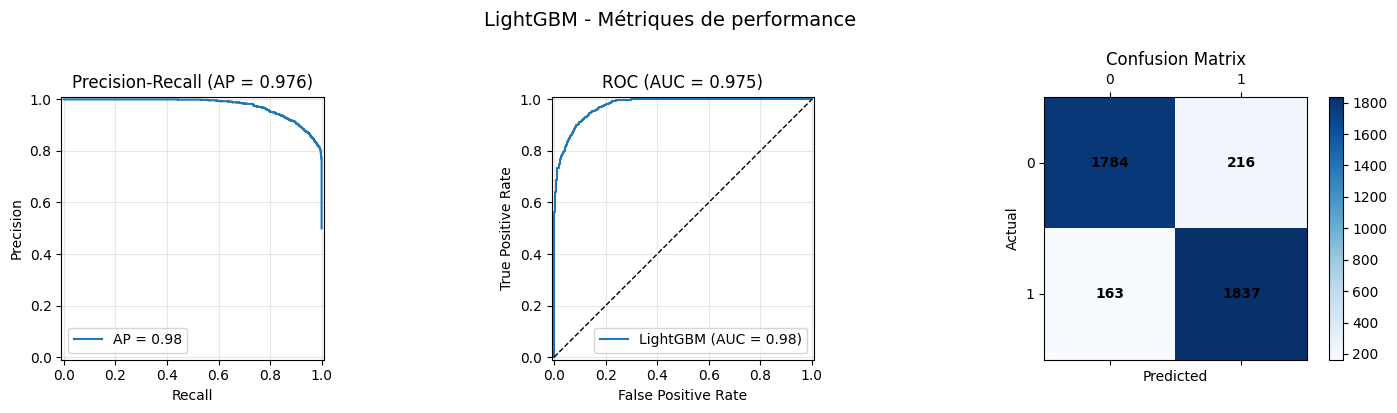

In [25]:
# Visualisation complète pour LightGBM : PR, ROC, Confusion Matrix

# Calculer les probabilités prédites
y_proba_lgbm = best_lgbm.predict_proba(X_test)[:, 1]

# Créer les 3 graphiques
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Courbe Precision-Recall
precision_lgbm, recall_lgbm, _ = precision_recall_curve(y_test, y_proba_lgbm)
ap_lgbm = average_precision_score(y_test, y_proba_lgbm)
display_pr_lgbm = PrecisionRecallDisplay(precision=precision_lgbm, recall=recall_lgbm, average_precision=ap_lgbm)
display_pr_lgbm.plot(ax=axes[0])
axes[0].set_title(f'Precision-Recall (AP = {ap_lgbm:.3f})')
axes[0].grid(alpha=0.3)

# 2. Courbe ROC
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_proba_lgbm)
roc_auc_lgbm = roc_auc_score(y_test, y_proba_lgbm)
display_roc_lgbm = RocCurveDisplay(fpr=fpr_lgbm, tpr=tpr_lgbm, roc_auc=roc_auc_lgbm, estimator_name='LightGBM')
display_roc_lgbm.plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_title(f'ROC (AUC = {roc_auc_lgbm:.3f})')
axes[1].grid(alpha=0.3)

# 3. Matrice de confusion
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
cax = axes[2].matshow(cm_lgbm, cmap='Blues')
for (i, j), val in np.ndenumerate(cm_lgbm):
    axes[2].text(j, i, int(val), ha='center', va='center', color='black', fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_title('Confusion Matrix')
fig.colorbar(cax, ax=axes[2])

plt.suptitle('LightGBM - Métriques de performance', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Top 20 features les plus importantes (LightGBM) :
                               feature  importance
                    num__person_income        1978
                    num__loan_int_rate        1405
                     num__credit_score        1146
                        num__loan_amnt         833
              num__loan_percent_income         702
                       num__person_age         476
                   num__person_emp_exp         399
       num__cb_person_cred_hist_length         348
        cat__person_home_ownership_OWN         201
              cat__loan_intent_VENTURE         188
       cat__person_home_ownership_RENT         185
              cat__loan_intent_MEDICAL         157
cat__previous_loan_defaults_on_file_No         154
    cat__loan_intent_DEBTCONSOLIDATION         118
      cat__loan_intent_HOMEIMPROVEMENT         110
            cat__loan_intent_EDUCATION          99
   cat__person_home_ownership_MORTGAGE          97
             cat__person_gender_

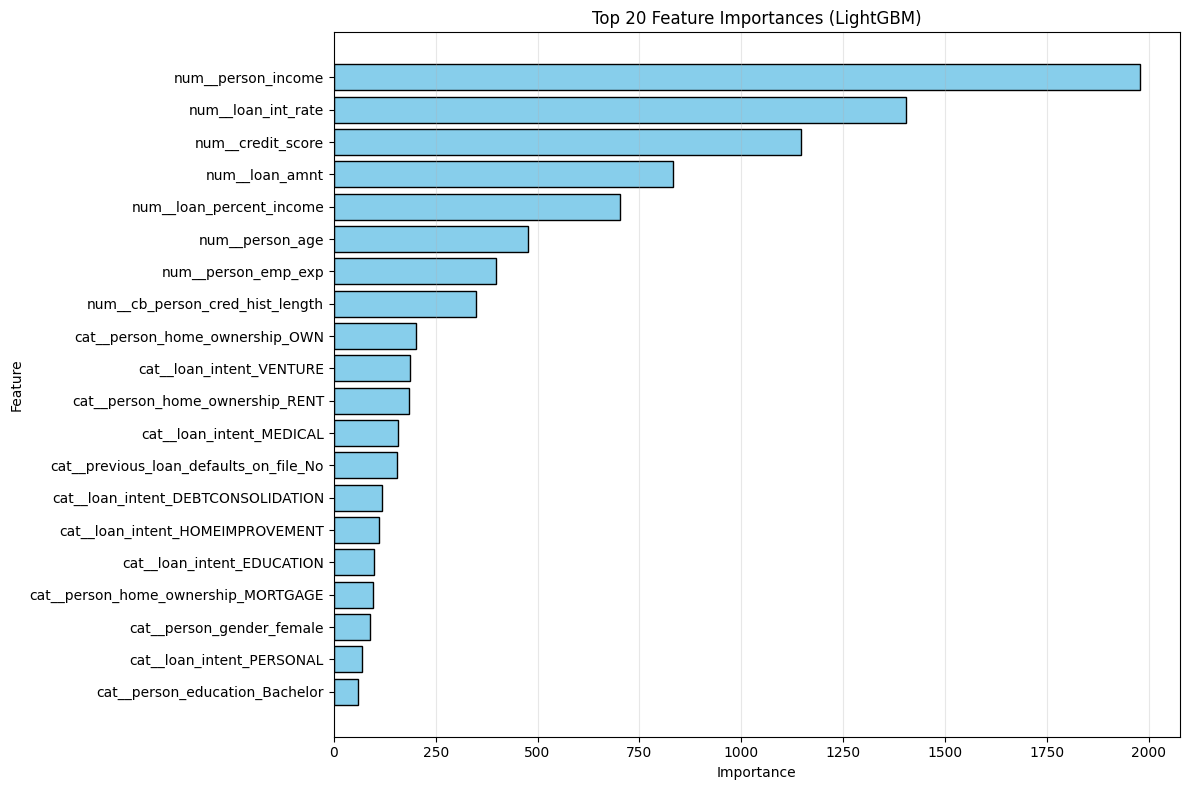

In [26]:
# Importance des features pour LightGBM

# Obtenir les noms des features après transformation (utiliser le preprocessor du modèle entraîné)
feature_names = best_lgbm.named_steps['preprocessor'].get_feature_names_out()

# Obtenir les importances des features
feature_importances = best_lgbm.named_steps['clf'].feature_importances_

# Créer un DataFrame pour faciliter le tri et la visualisation
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# Afficher les 20 features les plus importantes
print("Top 20 features les plus importantes (LightGBM) :")
print(importance_df.head(20).to_string(index=False))

# Graphique des importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['feature'][:20], importance_df['importance'][:20], color='skyblue', edgecolor='black')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances (LightGBM)')
plt.gca().invert_yaxis()  # Inverser pour avoir la plus importante en haut
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Pipeline avec XGBoost

## XGBoost (eXtreme Gradient Boosting)

XGBoost est un algorithme de boosting optimisé qui améliore les arbres de décision en ajoutant des termes de **régularisation** et en utilisant une **optimisation de second ordre** (Taylor). Il gère efficacement les valeurs manquantes et offre une parallélisation avancée.

**Formule de boosting :**

$$
\hat{y}_i = \sum_{k=1}^K f_k(x_i), \quad f_k \in \mathcal{F}
$$

où $\mathcal{F}$ est l'espace des arbres de décision.

**Fonction objectif :**

$$
\mathcal{L}^{(t)} = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)) + \Omega(f_t)
$$

avec $\Omega(f) = \gamma T + \frac{1}{2} \lambda \|w\|^2$, où $T$ est le nombre de feuilles, $w$ les poids des feuilles.

**Approximation de second ordre (Taylor) :**

$$
\mathcal{L}^{(t)} \approx \sum_{i=1}^n [g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t)
$$

où $g_i = \partial_{\hat{y}^{(t-1)}} l(y_i, \hat{y}^{(t-1)})$, $h_i = \partial_{\hat{y}^{(t-1)}}^2 l(y_i, \hat{y}^{(t-1)})$.

**Gain de division :**

$$
\text{Gain} = \frac{1}{2} \left[ \frac{(\sum_{i \in I_L} g_i)^2}{\sum_{i \in I_L} h_i + \lambda} + \frac{(\sum_{i \in I_R} g_i)^2}{\sum_{i \in I_R} h_i + \lambda} - \frac{(\sum_{i \in I} g_i)^2}{\sum_{i \in I} h_i + \lambda} \right] - \gamma
$$

In [27]:
from xgboost import XGBClassifier

# Pipeline avec XGBoost (sans restriction de thread)
pipe_xgb = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', XGBClassifier(random_state=42, eval_metric='logloss'))
])

# GridSearch avec parallélisme complet
param_grid_xgb = {
    'clf__n_estimators': [200, 500],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [ 0.3, 0.5, 0.8, 1],
    'clf__subsample': [0.8, 1.0]
}

# n_jobs=-1 utilise tous les cœurs CPU
gs_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=5, scoring='f1', n_jobs=-1, verbose=1)
gs_xgb.fit(X_train, y_train)

print('Best params:', gs_xgb.best_params_)
best_xgb = gs_xgb.best_estimator_

# Évaluation sur test
y_pred_xgb = best_xgb.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred_xgb))
print('\nClassification report:\n', classification_report(y_test, y_pred_xgb))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params: {'clf__learning_rate': 0.3, 'clf__max_depth': 3, 'clf__n_estimators': 500, 'clf__subsample': 1.0}
Test accuracy: 0.904

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      2000
           1       0.90      0.92      0.91      2000

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



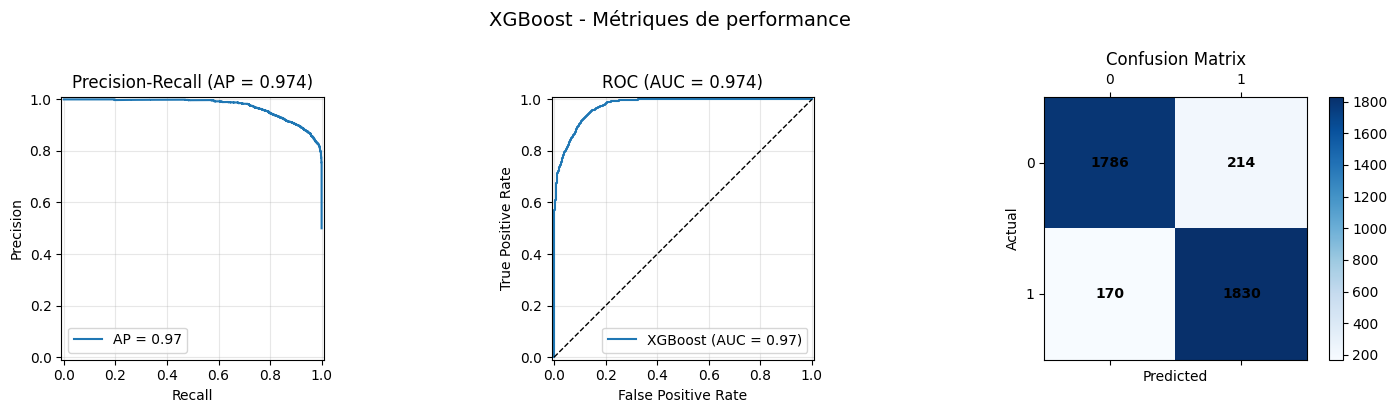

In [28]:
# Visualisation complète pour XGBoost : PR, ROC, Confusion Matrix

# Calculer les probabilités prédites
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Créer les 3 graphiques
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Courbe Precision-Recall
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)
ap_xgb = average_precision_score(y_test, y_proba_xgb)
display_pr_xgb = PrecisionRecallDisplay(precision=precision_xgb, recall=recall_xgb, average_precision=ap_xgb)
display_pr_xgb.plot(ax=axes[0])
axes[0].set_title(f'Precision-Recall (AP = {ap_xgb:.3f})')
axes[0].grid(alpha=0.3)

# 2. Courbe ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
display_roc_xgb = RocCurveDisplay(fpr=fpr_xgb, tpr=tpr_xgb, roc_auc=roc_auc_xgb, estimator_name='XGBoost')
display_roc_xgb.plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_title(f'ROC (AUC = {roc_auc_xgb:.3f})')
axes[1].grid(alpha=0.3)

# 3. Matrice de confusion
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cax = axes[2].matshow(cm_xgb, cmap='Blues')
for (i, j), val in np.ndenumerate(cm_xgb):
    axes[2].text(j, i, int(val), ha='center', va='center', color='black', fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_title('Confusion Matrix')
fig.colorbar(cax, ax=axes[2])

plt.suptitle('XGBoost - Métriques de performance', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Adaboost

## AdaBoost (Adaptive Boosting)

AdaBoost est un algorithme de boosting qui ajuste itérativement les poids des échantillons d'entraînement pour se concentrer sur les erreurs précédentes. Il combine plusieurs classifieurs faibles (souvent des arbres de décision simples) en une prédiction forte.

**Formule de prédiction :**

$$
\hat{y}(x) = \text{sign}\left( \sum_{t=1}^T \alpha_t h_t(x) \right)
$$

où $h_t$ est le classifieur faible à l'itération $t$, et $\alpha_t$ est son poids.

**Calcul des poids des classifieurs :**

$$
\alpha_t = \frac{1}{2} \ln\left( \frac{1 - \epsilon_t}{\epsilon_t} \right)
$$

où $\epsilon_t$ est le taux d'erreur pondéré du classifieur $h_t$.

**Mise à jour des poids des échantillons :**

$$
w_{t+1,i} = w_{t,i} \exp(-\alpha_t y_i h_t(x_i))
$$

normalisé pour que $\sum w_{t+1,i} = 1$.

**Erreur pondérée :**

$$
\epsilon_t = \sum_{i=1}^n w_{t,i} I(y_i \neq h_t(x_i))
$$

In [29]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Pipeline avec AdaBoost
pipe_ada = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', AdaBoostClassifier(random_state=42, algorithm='SAMME'))
])

# GridSearch pour AdaBoost
param_grid_ada = {
    'clf__n_estimators': [300, 500, 700],
    'clf__learning_rate': [ 1.0, 1.5, 2],
    'clf__estimator': [
        DecisionTreeClassifier(max_depth=3),
        DecisionTreeClassifier(max_depth=4),
        DecisionTreeClassifier(max_depth=5)
    ]
}

gs_ada = GridSearchCV(pipe_ada, param_grid_ada, cv=5, scoring='f1', n_jobs=-1, verbose=1)
gs_ada.fit(X_train, y_train)

print('Best params:', gs_ada.best_params_)
best_ada = gs_ada.best_estimator_

# Évaluation
y_pred_ada = best_ada.predict(X_test)
y_proba_ada = best_ada.predict_proba(X_test)[:, 1]

print(f'Test accuracy: {accuracy_score(y_test, y_pred_ada):.4f}')
print(f'Test F1-score: {f1_score(y_test, y_pred_ada):.4f}')
print('\nClassification report:\n', classification_report(y_test, y_pred_ada))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params: {'clf__estimator': DecisionTreeClassifier(max_depth=5), 'clf__learning_rate': 1.0, 'clf__n_estimators': 500}
Test accuracy: 0.9042
Test F1-score: 0.9050

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.90      2000
           1       0.90      0.91      0.91      2000

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



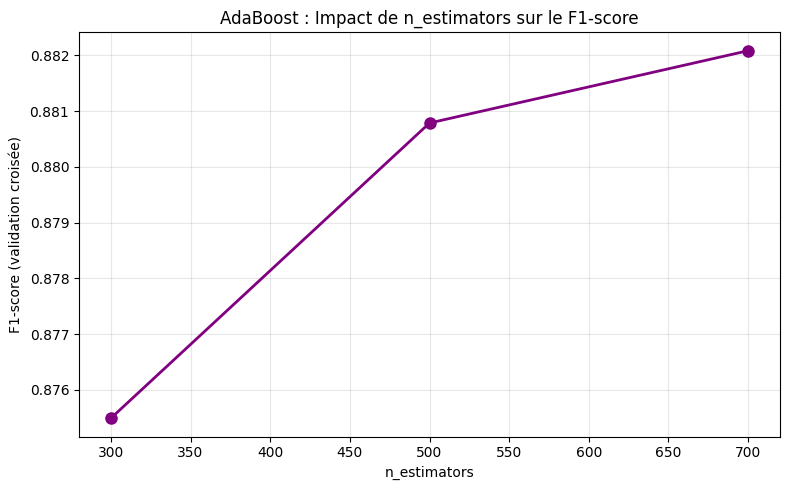


AdaBoost - F1-score moyen par n_estimators :
  • n_estimators=300: F1=0.8755
  • n_estimators=500: F1=0.8808
  • n_estimators=700: F1=0.8821


In [30]:
# Analyser l'impact de n_estimators sur AdaBoost
cv_results_ada = pd.DataFrame(gs_ada.cv_results_)

# Extraire les valeurs uniques
n_ests_ada = sorted(cv_results_ada['param_clf__n_estimators'].unique())
learning_rates_ada = sorted(cv_results_ada['param_clf__learning_rate'].unique())

# Calculer la moyenne du F1-score pour chaque n_estimators (moyenne sur les autres hyperparamètres)
means_n_ada = []
for n_est in n_ests_ada:
    mask = cv_results_ada['param_clf__n_estimators'] == n_est
    data = cv_results_ada[mask]['mean_test_score'].values
    means_n_ada.append(data.mean())

# Graphique
plt.figure(figsize=(8, 5))
plt.plot(n_ests_ada, means_n_ada, 'o-', linewidth=2, markersize=8, color='purple')
plt.xlabel('n_estimators')
plt.ylabel('F1-score (validation croisée)')
plt.title('AdaBoost : Impact de n_estimators sur le F1-score')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Afficher les valeurs
print("\nAdaBoost - F1-score moyen par n_estimators :")
for n_est, mean_f1 in zip(n_ests_ada, means_n_ada):
    print(f"  • n_estimators={n_est}: F1={mean_f1:.4f}")

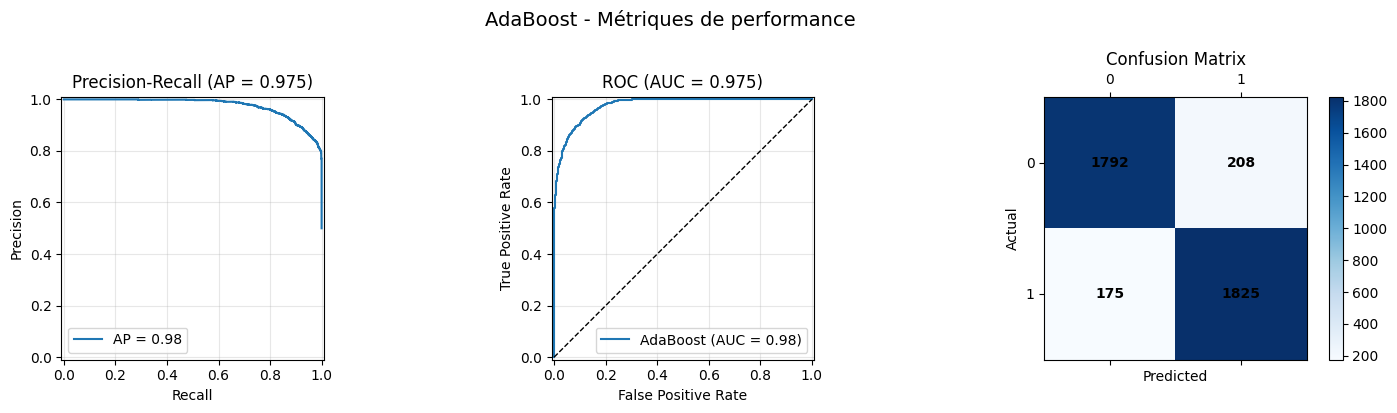

In [31]:
# Visualisation AdaBoost : PR, ROC, Confusion Matrix
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Precision-Recall
precision_ada, recall_ada, _ = precision_recall_curve(y_test, y_proba_ada)
ap_ada = average_precision_score(y_test, y_proba_ada)
PrecisionRecallDisplay(precision=precision_ada, recall=recall_ada, average_precision=ap_ada).plot(ax=axes[0])
axes[0].set_title(f'Precision-Recall (AP = {ap_ada:.3f})')
axes[0].grid(alpha=0.3)

# 2. ROC
fpr_ada, tpr_ada, _ = roc_curve(y_test, y_proba_ada)
roc_auc_ada = roc_auc_score(y_test, y_proba_ada)
RocCurveDisplay(fpr=fpr_ada, tpr=tpr_ada, roc_auc=roc_auc_ada, estimator_name='AdaBoost').plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_title(f'ROC (AUC = {roc_auc_ada:.3f})')
axes[1].grid(alpha=0.3)

# 3. Confusion Matrix
cm_ada = confusion_matrix(y_test, y_pred_ada)
cax = axes[2].matshow(cm_ada, cmap='Blues')
for (i, j), val in np.ndenumerate(cm_ada):
    axes[2].text(j, i, int(val), ha='center', va='center', color='black', fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_title('Confusion Matrix')
fig.colorbar(cax, ax=axes[2])

plt.suptitle('AdaBoost - Métriques de performance', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## HistGradientClassifier

## HistGradientBoosting

**HistGradientBoosting** est une implémentation optimisée de **gradient boosting** qui utilise des **histogrammes** pour accélérer l'entraînement sur de grands jeux de données. Il gère nativement les valeurs manquantes et utilise des arbres binaires pour la classification.

**Formule de boosting :**

$$
F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)
$$

où $h_m(x)$ est un arbre de décision entraîné sur les résidus (pseudo-résidus ou gradients) et $\eta$ est le taux d'apprentissage.

**Fonction de perte :**

$$
\mathcal{L}(F) = \sum_{i=1}^n l(y_i, F(x_i))
$$

Pour la classification binaire, souvent la log-loss :

$$
l(y, F) = \log(1 + \exp(-2yF))
$$

**Optimisation par histogrammes :**

Les features sont discrétisées en histogrammes pour réduire le coût de calcul des divisions. Le calcul des statistiques (gradients $g_i$ et hessians $h_i$) pour chaque **bin** d'histogramme est :

$$
\text{Hist}_g(j, b) = \sum_{i: x_{i,j} \in \text{bin } b} g_i, \quad \text{Hist}_h(j, b) = \sum_{i: x_{i,j} \in \text{bin } b} h_i
$$

où $j$ est l'index de la feature et $b$ est le *bin* (compartiment) de l'histogramme.

**Gain de division :**

Le critère de gain (lié à la réduction de la perte) lors d'une division est approximé en utilisant les sommes des gradients et des hessians des bins gauche ($L$) et droit ($R$) :

$$
\text{Gain} = \frac{(\sum_{i \in L} g_i)^2}{\sum_{i \in L} h_i} + \frac{(\sum_{i \in R} g_i)^2}{\sum_{i \in R} h_i} - \frac{(\sum_{i} g_i)^2}{\sum_{i} h_i}
$$

Fitting 5 folds for each of 54 candidates, totalling 270 fits


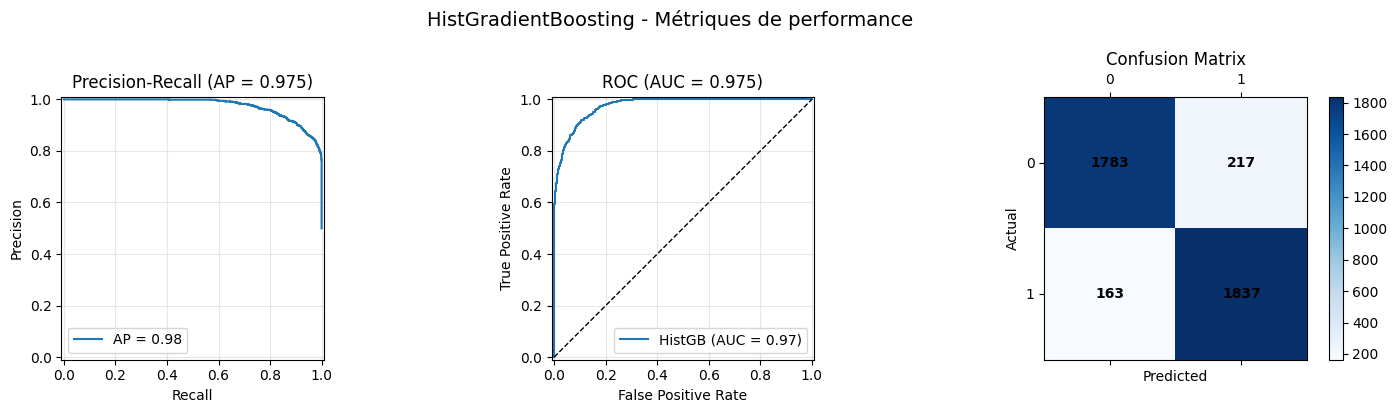

In [32]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Pipeline avec HistGradientBoostingClassifier
pipe_hgb = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', HistGradientBoostingClassifier(random_state=42))
])

# Grille d'hyperparamètres
param_grid_hgb = {
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__max_iter': [300, 500],
    'clf__max_depth': [3, 5, 7],
    'clf__l2_regularization': [0, 1, 10]
}

gs_hgb = GridSearchCV(
    pipe_hgb,
    param_grid=param_grid_hgb,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
gs_hgb.fit(X_train, y_train)
best_hgb = gs_hgb.best_estimator_
y_pred_hgb = best_hgb.predict(X_test)
y_proba_hgb = best_hgb.predict_proba(X_test)[:, 1]

# Visualisation : PR, ROC, Matrice de confusion
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Precision-Recall
precision_hgb, recall_hgb, _ = precision_recall_curve(y_test, y_proba_hgb)
ap_hgb = average_precision_score(y_test, y_proba_hgb)
PrecisionRecallDisplay(precision=precision_hgb, recall=recall_hgb, average_precision=ap_hgb).plot(ax=axes[0])
axes[0].set_title(f'Precision-Recall (AP = {ap_hgb:.3f})')
axes[0].grid(alpha=0.3)

# ROC
fpr_hgb, tpr_hgb, _ = roc_curve(y_test, y_proba_hgb)
roc_auc_hgb = roc_auc_score(y_test, y_proba_hgb)
RocCurveDisplay(fpr=fpr_hgb, tpr=tpr_hgb, roc_auc=roc_auc_hgb, estimator_name='HistGB').plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_title(f'ROC (AUC = {roc_auc_hgb:.3f})')
axes[1].grid(alpha=0.3)

# Matrice de confusion
cm_hgb = confusion_matrix(y_test, y_pred_hgb)
cax = axes[2].matshow(cm_hgb, cmap='Blues')
for (i, j), val in np.ndenumerate(cm_hgb):
    axes[2].text(j, i, int(val), ha='center', va='center', color='black', fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_title('Confusion Matrix')
fig.colorbar(cax, ax=axes[2])

plt.suptitle('HistGradientBoosting - Métriques de performance', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Vérification de la cohérence des scores et des erreurs des modèles.

On vérifie si les erreurs sur les prédictions sont les même ou si elles varient suivant les modèles

                      Precision  Recall        F1
Model                                            
Logistic Regression    0.847229  0.9095  0.877261
Random Forest          0.878037  0.9215  0.899244
Extra Trees            0.846570  0.9380  0.889943
LightGBM               0.894788  0.9185  0.906489
XGBoost                0.895303  0.9150  0.905045
AdaBoost               0.897688  0.9125  0.905033
HistGradientBoosting   0.894352  0.9185  0.906265
Total Faux Positifs (tous modèles cumulés) : 1779
Total Faux Négatifs (tous modèles cumulés) : 1133


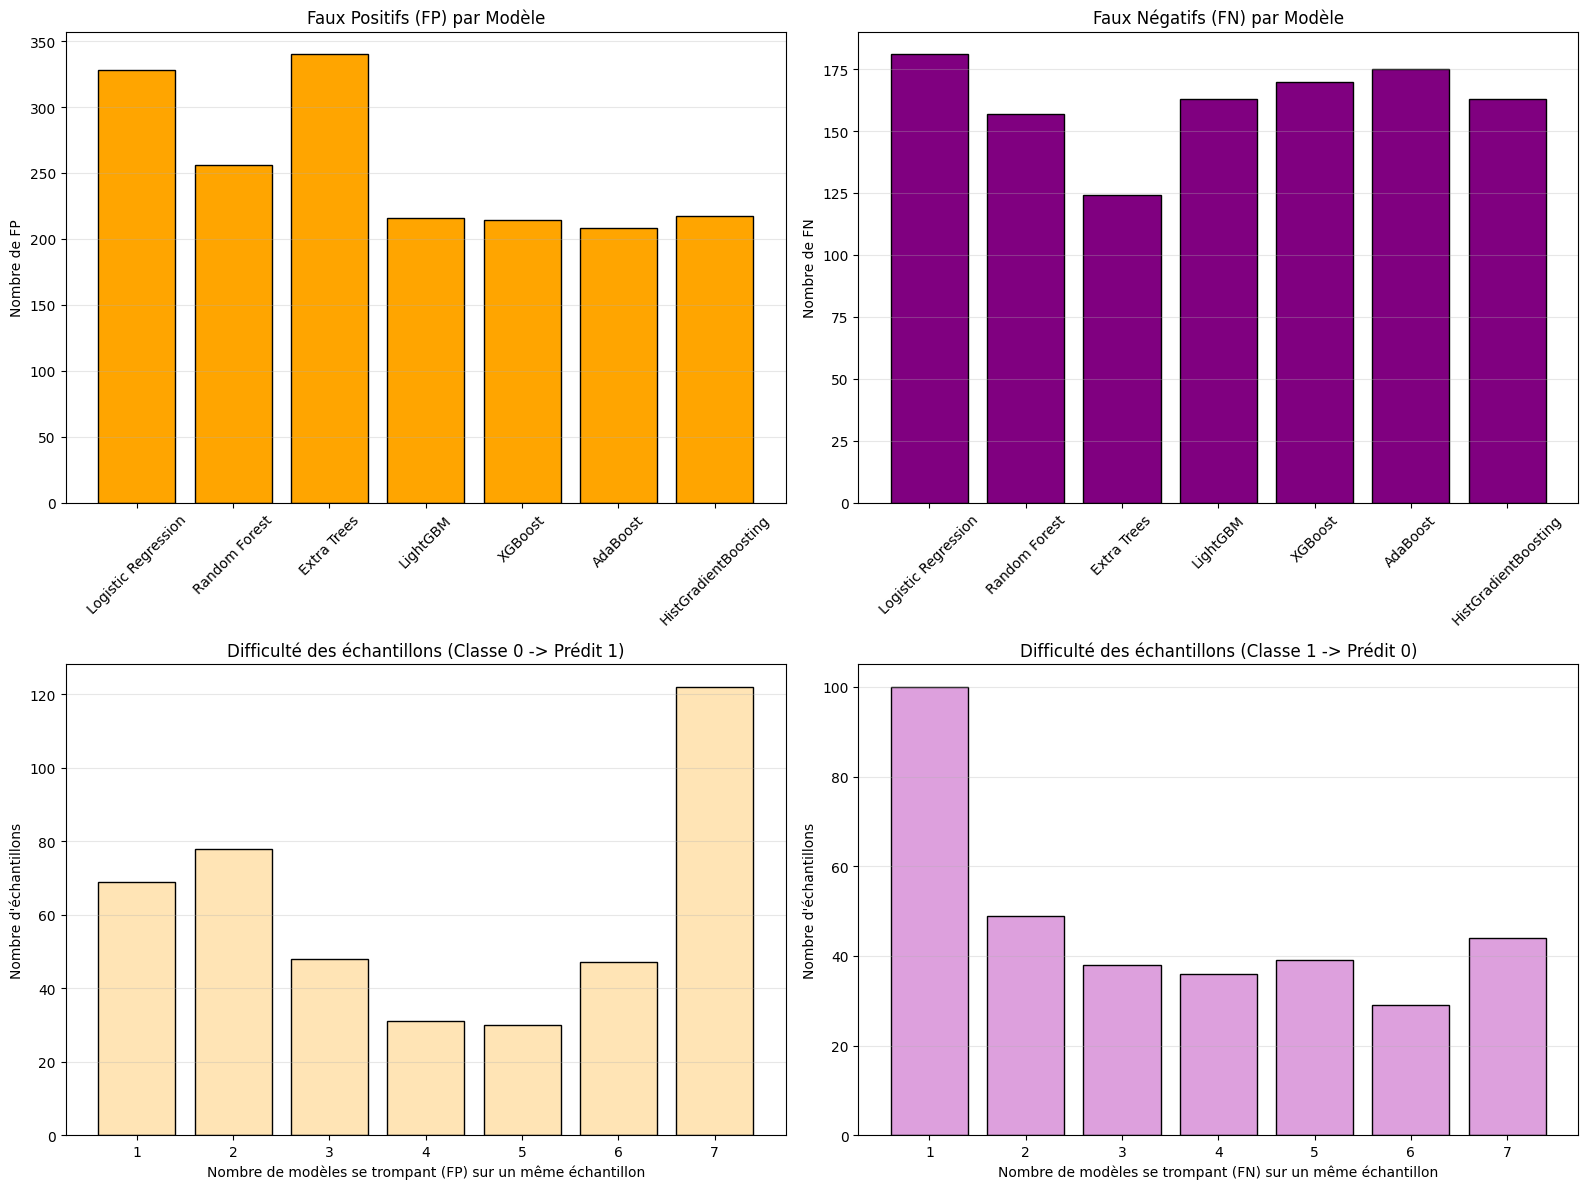

In [33]:

models = {
    'Logistic Regression': best_lr.predict(X_test),
    'Random Forest': best_rf.predict(X_test),
    'Extra Trees': best_etc.predict(X_test),
    'LightGBM': best_lgbm.predict(X_test),
    'XGBoost': best_xgb.predict(X_test),
    'AdaBoost': best_ada.predict(X_test),
    'HistGradientBoosting': best_hgb.predict(X_test)
}

# Création du DataFrame des métriques
metrics_data = []
for name, preds in models.items():
    metrics_data.append({
        'Model': name,
        'Precision': precision_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'F1': f1_score(y_test, preds)
    })

df_metrics = pd.DataFrame(metrics_data).set_index('Model')
print(df_metrics)

# 1. Calculer FP et FN par modèle
fp_by_model = {}
fn_by_model = {}

for name, y_pred in models.items():
    cm = confusion_matrix(y_test, y_pred)
    # cm structure: [[TN, FP], [FN, TP]]
    fp_by_model[name] = cm[0, 1]
    fn_by_model[name] = cm[1, 0]

# 2. Calculer les erreurs par échantillon (Sample-wise)
# On initialise des compteurs de zéros
fp_counts_per_sample = np.zeros(len(y_test))
fn_counts_per_sample = np.zeros(len(y_test))

# On s'assure que y_test est un array numpy pour les masques
y_test_arr = np.array(y_test)

for name, y_pred in models.items():
    # Faux Positifs : Le modèle prédit 1 alors que c'est 0
    fp_mask = (y_pred == 1) & (y_test_arr == 0)
    fp_counts_per_sample[fp_mask] += 1
    
    # Faux Négatifs : Le modèle prédit 0 alors que c'est 1
    fn_mask = (y_pred == 0) & (y_test_arr == 1)
    fn_counts_per_sample[fn_mask] += 1

# Prints simples pour info
print(f"Total Faux Positifs (tous modèles cumulés) : {sum(fp_by_model.values())}")
print(f"Total Faux Négatifs (tous modèles cumulés) : {sum(fn_by_model.values())}")

# --- VISUALISATION 2x2 ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# HAUT GAUCHE : FP par Modèle
axes[0, 0].bar(fp_by_model.keys(), fp_by_model.values(), color='orange', edgecolor='black')
axes[0, 0].set_title('Faux Positifs (FP) par Modèle')
axes[0, 0].set_ylabel('Nombre de FP')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# HAUT DROITE : FN par Modèle
axes[0, 1].bar(fn_by_model.keys(), fn_by_model.values(), color='purple', edgecolor='black')
axes[0, 1].set_title('Faux Négatifs (FN) par Modèle')
axes[0, 1].set_ylabel('Nombre de FN')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# BAS GAUCHE : Distribution des FP par échantillon
# On ne garde que les échantillons qui sont réellement négatifs (0) et qui ont au moins une erreur
mask_fp = (y_test_arr == 0) & (fp_counts_per_sample > 0)
unique_fp, counts_fp = np.unique(fp_counts_per_sample[mask_fp], return_counts=True)

axes[1, 0].bar(unique_fp, counts_fp, color='moccasin', edgecolor='black')
axes[1, 0].set_xlabel('Nombre de modèles se trompant (FP) sur un même échantillon')
axes[1, 0].set_ylabel('Nombre d\'échantillons')
axes[1, 0].set_title('Difficulté des échantillons (Classe 0 -> Prédit 1)')
axes[1, 0].grid(axis='y', alpha=0.3)

# BAS DROITE : Distribution des FN par échantillon
# On ne garde que les échantillons qui sont réellement positifs (1) et qui ont au moins une erreur
mask_fn = (y_test_arr == 1) & (fn_counts_per_sample > 0)
unique_fn, counts_fn = np.unique(fn_counts_per_sample[mask_fn], return_counts=True)

axes[1, 1].bar(unique_fn, counts_fn, color='plum', edgecolor='black')
axes[1, 1].set_xlabel('Nombre de modèles se trompant (FN) sur un même échantillon')
axes[1, 1].set_ylabel('Nombre d\'échantillons')
axes[1, 1].set_title('Difficulté des échantillons (Classe 1 -> Prédit 0)')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Intuition : on peut faire en sorte que les modèles votent tous ensembles, permettant de supprimer les erreurs faites par 1, 2, 3 modèles puisque au moins 4 autres modèles ne font pas ces fautes.

## Création d'un algorithme de vote simple utilisant les 7 modèles précédents et en séparant FP et FN

=== HARD VOTING ENSEMBLE PERFORMANCE ===
Accuracy : 0.9055
F1-Score : 0.9074
Precision: 0.8895
Recall   : 0.9260


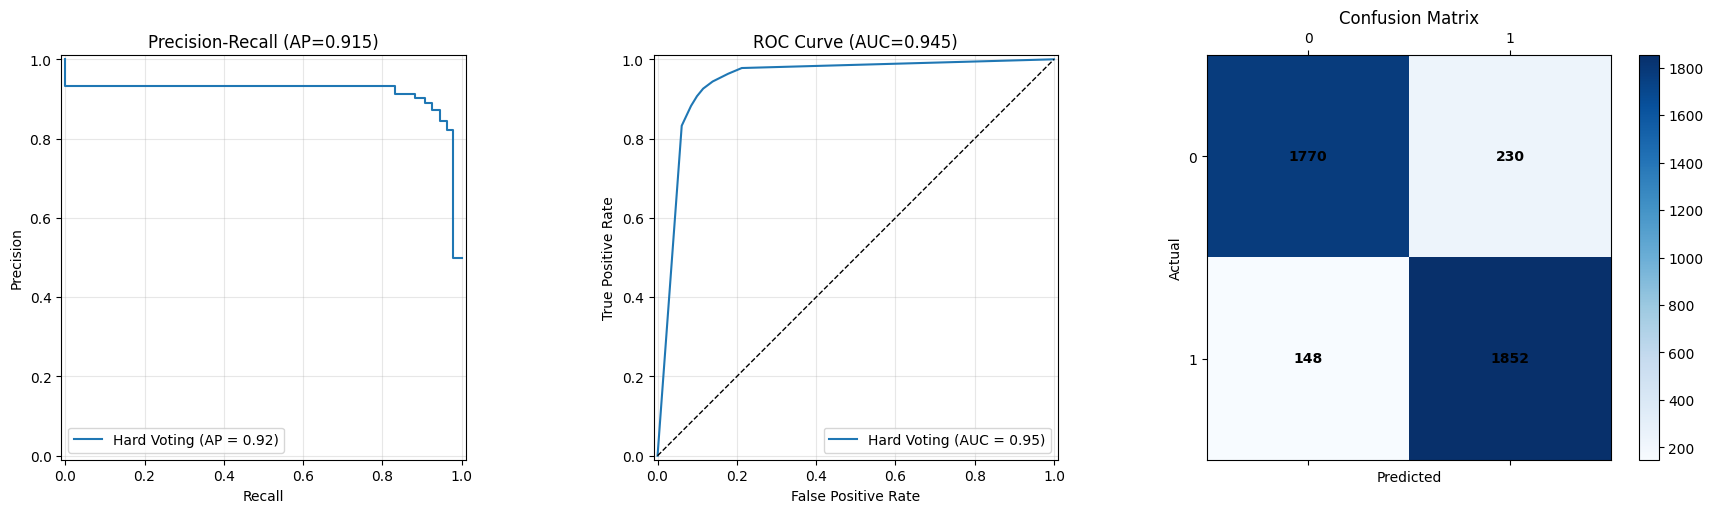

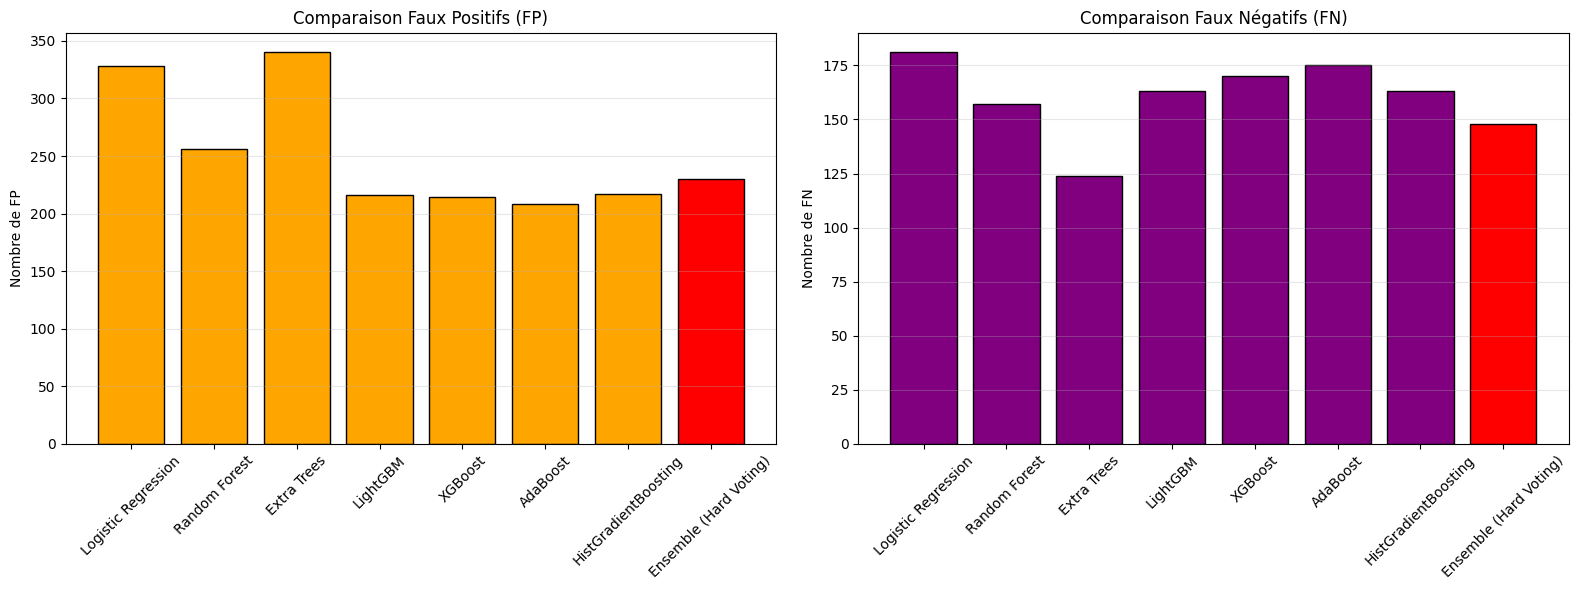

In [34]:

# --- 1. HARD VOTING ENSEMBLE ---

# Liste des modèles entraînés
estimators = [
    ('Logistic Regression', best_lr),
    ('Random Forest', best_rf),
    ('Extra Trees', best_etc),
    ('LightGBM', best_lgbm),
    ('XGBoost', best_xgb),
    ('AdaBoost', best_ada),
    ('HistGradientBoosting', best_hgb)
]

# Récupération des prédictions binaires de chaque modèle
all_preds = np.array([model.predict(X_test) for _, model in estimators])

# Vote majoritaire : si la moyenne des votes est >= 0.5, la classe est 1
y_pred_ensemble = (np.sum(all_preds, axis=0) > (len(estimators) / 2)).astype(int)

# Pour les courbes, on utilise la "fraction de votes positifs" comme pseudo-probabilité
y_proba_ensemble = np.mean(all_preds, axis=0)

# Affichage des métriques textuelles
print("=== HARD VOTING ENSEMBLE PERFORMANCE ===")
print(f"Accuracy : {accuracy_score(y_test, y_pred_ensemble):.4f}")
print(f"F1-Score : {f1_score(y_test, y_pred_ensemble):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_ensemble):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_ensemble):.4f}")

# --- 2. VISUALISATION PERFORMANCE (3 Subplots) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# A. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_ensemble)
ap = average_precision_score(y_test, y_proba_ensemble)
display_pr = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap)
display_pr.plot(ax=axes[0], name='Hard Voting')
axes[0].set_title(f'Precision-Recall (AP={ap:.3f})')
axes[0].grid(alpha=0.3)

# B. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_ensemble)
roc_auc = roc_auc_score(y_test, y_proba_ensemble)
display_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Hard Voting')
display_roc.plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_title(f'ROC Curve (AUC={roc_auc:.3f})')
axes[1].grid(alpha=0.3)

# C. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ensemble)
cax = axes[2].matshow(cm, cmap='Blues')
for (i, j), val in np.ndenumerate(cm):
    axes[2].text(j, i, int(val), ha='center', va='center', color='black', fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_title('Confusion Matrix')
fig.colorbar(cax, ax=axes[2])

plt.tight_layout()
plt.show()

# --- 3. COMPARAISON DES ERREURS (FP & FN) AVEC L'ENSEMBLE ---

# On reconstruit le dictionnaire des prédictions en ajoutant l'ensemble
models_preds = {name: model.predict(X_test) for name, model in estimators}
models_preds['Ensemble (Hard Voting)'] = y_pred_ensemble

# Calcul des FP et FN par modèle
fp_by_model = {}
fn_by_model = {}

for name, pred in models_preds.items():
    cm_curr = confusion_matrix(y_test, pred)
    fp_by_model[name] = cm_curr[0, 1]
    fn_by_model[name] = cm_curr[1, 0]

# Visualisation comparative
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))

# Graphique FP
colors_fp = ['orange'] * (len(fp_by_model)-1) + ['red'] # Rouge pour l'ensemble
axes2[0].bar(fp_by_model.keys(), fp_by_model.values(), color=colors_fp, edgecolor='black')
axes2[0].set_title('Comparaison Faux Positifs (FP)')
axes2[0].set_ylabel('Nombre de FP')
axes2[0].tick_params(axis='x', rotation=45, labelsize=10)
axes2[0].grid(axis='y', alpha=0.3)

# Graphique FN
colors_fn = ['purple'] * (len(fn_by_model)-1) + ['red'] # Rouge pour l'ensemble
axes2[1].bar(fn_by_model.keys(), fn_by_model.values(), color=colors_fn, edgecolor='black')
axes2[1].set_title('Comparaison Faux Négatifs (FN)')
axes2[1].set_ylabel('Nombre de FN')
axes2[1].tick_params(axis='x', rotation=45, labelsize=10)
axes2[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Nombre d'erreurs de l'Ensemble : 378


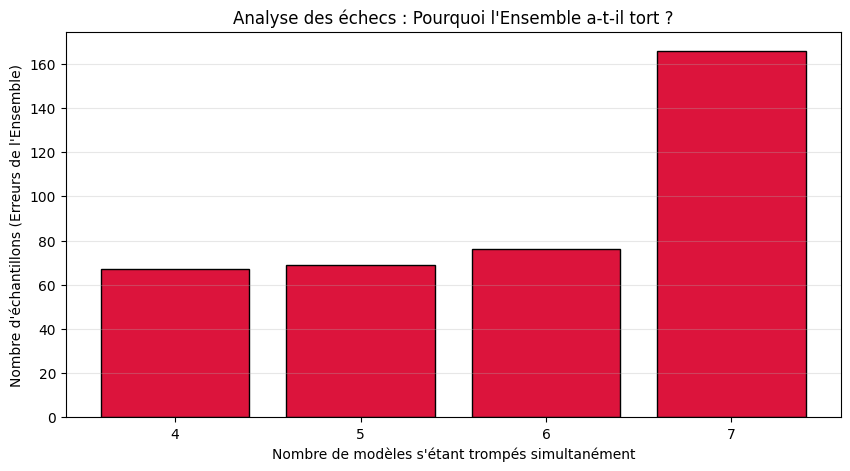


Qui tire l'ensemble vers le bas ?
(Pourcentage d'erreur du modèle quand l'ensemble se trompe)
HistGradientBoosting    0.891534
LightGBM                0.888889
Random Forest           0.875661
Logistic Regression     0.841270
Extra Trees             0.817460
AdaBoost                0.796296
XGBoost                 0.791005
dtype: float64


In [36]:


# 1. Récupérer les prédictions individuelles dans un DataFrame
df_preds = pd.DataFrame()
for name, model in estimators:
    df_preds[name] = model.predict(X_test)

# 2. Identifier UNIQUEMENT les cas où l'Ensemble s'est trompé
ensemble_errors_mask = (y_pred_ensemble != y_test.values)
X_errors = df_preds[ensemble_errors_mask]

# CORRECTION : On ajoute .values ici pour obtenir un tableau Numpy au lieu d'une Série avec index.
# Cela permet la comparaison avec X_errors (qui a un index différent) sans erreur.
y_true_errors = y_test.values[ensemble_errors_mask]

print(f"Nombre d'erreurs de l'Ensemble : {len(X_errors)}")

# 3. Sur ces erreurs, combien de modèles se sont trompés ?
# (Mathématiquement, ce sera forcément >= 4, sinon l'ensemble aurait eu juste)
nb_modeles_faux = X_errors.apply(lambda col: col != y_true_errors, axis=0).sum(axis=1)


# 4. Visualisation de la cause de l'échec
plt.figure(figsize=(10, 5))
counts = nb_modeles_faux.value_counts().sort_index()
bars = plt.bar(counts.index, counts.values, color='crimson', edgecolor='black')
plt.xlabel("Nombre de modèles s'étant trompés simultanément")
plt.ylabel("Nombre d'échantillons (Erreurs de l'Ensemble)")
plt.title("Analyse des échecs : Pourquoi l'Ensemble a-t-il tort ?")
plt.xticks(range(4, 8)) # On affiche 4, 5, 6, 7
plt.grid(axis='y', alpha=0.3)
plt.show()

# 5. Qui sont les coupables ? (Quels modèles se trompent le plus quand l'ensemble échoue ?)
error_rate_when_ensemble_fails = X_errors.apply(lambda col: col != y_true_errors, axis=0).mean()
print("\nQui tire l'ensemble vers le bas ?")
print("(Pourcentage d'erreur du modèle quand l'ensemble se trompe)")
print(error_rate_when_ensemble_fails.sort_values(ascending=False))

### Soft

Voting Ensemble - F1: 0.9058, Precision: 0.8850, Recall: 0.9275


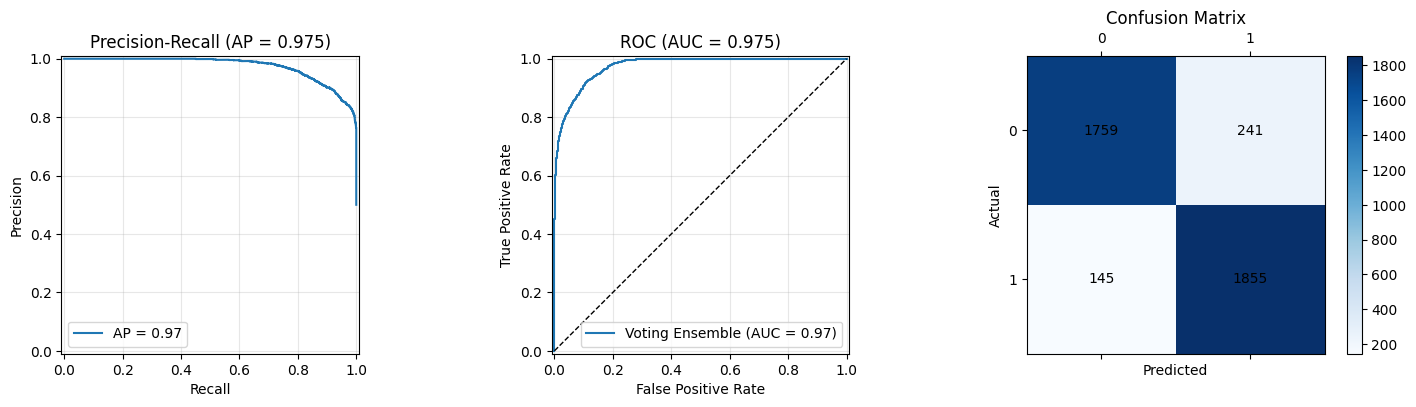

In [37]:
# Liste des modèles entraînés
models = [
    ('Logistic Regression', best_lr),
    ('Random Forest', best_rf),
    ('Extra Trees', best_etc),
    ('LightGBM', best_lgbm),
    ('XGBoost', best_xgb),
    ('AdaBoost', best_ada),
    ('HistGradientBoosting', best_hgb)
]

# Collecter les probabilités pour soft voting
proba_list = []
for name, model in models:
    proba = model.predict_proba(X_test)[:, 1]
    proba_list.append(proba)

# Moyenne des probabilités (soft voting)
y_proba_voting = np.mean(proba_list, axis=0)

# Prédictions binaires (seuil 0.5)
y_pred_voting = (y_proba_voting >= 0.5).astype(int)

# Métriques
f1 = f1_score(y_test, y_pred_voting)
precision = precision_score(y_test, y_pred_voting)
recall = recall_score(y_test, y_pred_voting)

print(f"Voting Ensemble - F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Visualisations comme pour Logistic Regression
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Courbe Precision-Recall
precision_v, recall_v, _ = precision_recall_curve(y_test, y_proba_voting)
ap_v = average_precision_score(y_test, y_proba_voting)
display_pr_v = PrecisionRecallDisplay(precision=precision_v, recall=recall_v, average_precision=ap_v)
display_pr_v.plot(ax=axes[0])
axes[0].set_title(f'Precision-Recall (AP = {ap_v:.3f})')
axes[0].grid(alpha=0.3)

# 2. Courbe ROC
fpr_v, tpr_v, _ = roc_curve(y_test, y_proba_voting)
roc_auc_v = roc_auc_score(y_test, y_proba_voting)
display_roc_v = RocCurveDisplay(fpr=fpr_v, tpr=tpr_v, roc_auc=roc_auc_v, estimator_name='Voting Ensemble')
display_roc_v.plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_title(f'ROC (AUC = {roc_auc_v:.3f})')
axes[1].grid(alpha=0.3)

# 3. Matrice de confusion
cm_v = confusion_matrix(y_test, y_pred_voting)
cax = axes[2].matshow(cm_v, cmap='Blues')
for (i, j), val in np.ndenumerate(cm_v):
    axes[2].text(j, i, int(val), ha='center', va='center', color='black')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_title('Confusion Matrix')
fig.colorbar(cax, ax=axes[2])

plt.tight_layout()
plt.show()

# Réseau de neurones (PyTorch)
Dans cette section, nous construisons un réseau de neurones entièrement connecté (*Multi-Layer Perceptron*) en utilisant PyTorch, afin de proposer une alternative plus flexible aux modèles classiques (Logistic Regression, SVM, KNN, etc.).

Métiel du pipeline :
- **GELU** : une activation plus performante que ReLU pour les réseaux profonds.  
- **Batch Normalization** : stabilise et accélère l'entraînement.  
- **Dropout** : régularisation légère pour réduire le surapprentissage.  
- **Skip Connection (résiduelle)** : améliore la propagation du gradient.  
- **Projection du skip** : permet d'additionner des tenseurs de dimensions différentes (128 → 64).  
- **Initialisation Kaiming/He** : adaptée aux activations GELU/LeakyReLU.  
- **Gradient Clipping** : évite l'exploding gradient.  
- **OneCycleLR** : scheduler moderne permettant une convergence plus rapide et plus stable.  
- **Early Stopping** : arrête l'entraînement dès que la perte ne s'améliore plus.


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np

# ===================================================================
# 1) Préparation des données
# ===================================================================
X_train = X_train.apply(pd.to_numeric, errors="coerce").fillna(0).astype(np.float32)
X_test  = X_test.apply(pd.to_numeric, errors="coerce").fillna(0).astype(np.float32)

# Normalisation (fortement recommandé pour les MLP)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Conversion en tenseurs
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.long)
y_test_t  = torch.tensor(y_test.values, dtype=torch.long)

# Split validation
X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(
    X_train_t, y_train_t, test_size=0.2, random_state=42
)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=64, shuffle=False)


# ===================================================================
# 2) Modèle amélioré + skip connection + init
# ===================================================================
class DeepMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.1)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Dropout(0.1)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(0.1)
        )

        self.skip_proj = nn.Linear(128, 64)
        self.output = nn.Linear(32, 2)

        self.apply(self._init_weights)

    def _init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_uniform_(layer.weight, nonlinearity="leaky_relu")
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = self.layer1(x)
        skip = self.skip_proj(x)
        x = self.layer2(x) + skip
        x = self.layer3(x)
        return self.output(x)


mlp = DeepMLP(X_train.shape[1])

# ===================================================================
# 3) OPTIMIZER & SCHEDULER
# ===================================================================
optimizer = optim.AdamW(mlp.parameters(), lr=1e-3, weight_decay=1e-4)   # meilleure régularisation
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)    # descente douce et stable

criterion = nn.CrossEntropyLoss()

# ===================================================================
# 4) Entraînement avec validation + early stopping propre
# ===================================================================
best_val_loss = float("inf")
patience = 5
wait = 0

EPOCHS = 30

for epoch in range(EPOCHS):
    mlp.train()
    train_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = mlp(xb)
        loss = criterion(preds, yb)
        loss.backward()

        nn.utils.clip_grad_norm_(mlp.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()

    scheduler.step()

    # ------- VALIDATION -------
    mlp.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            val_loss += criterion(mlp(xb), yb).item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss/len(train_loader):.4f} | "
          f"Val Loss: {val_loss/len(val_loader):.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

    # Early stopping → basé sur VALIDATION LOSS
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = mlp.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("\nEarly stopping activé \n")
            break

# Charger le meilleur modèle obtenu
mlp.load_state_dict(best_model)

# ===================================================================
# 5) Évaluation finale
# ===================================================================
mlp.eval()
with torch.no_grad():
    preds_test = mlp(X_test_t).argmax(1).numpy()

print("\nRésultats finaux\n")
print("Accuracy :", accuracy_score(y_test, preds_test))
print("\nMatrice de confusion:\n", confusion_matrix(y_test, preds_test))
print("\nClassification report:\n", classification_report(y_test, preds_test))


Epoch 1/30 | Train Loss: 0.5227 | Val Loss: 0.4806 | LR: 0.000994
Epoch 2/30 | Train Loss: 0.4938 | Val Loss: 0.4770 | LR: 0.000976
Epoch 3/30 | Train Loss: 0.4924 | Val Loss: 0.4784 | LR: 0.000946
Epoch 4/30 | Train Loss: 0.4880 | Val Loss: 0.4773 | LR: 0.000905
Epoch 5/30 | Train Loss: 0.4869 | Val Loss: 0.4771 | LR: 0.000854
Epoch 6/30 | Train Loss: 0.4845 | Val Loss: 0.4742 | LR: 0.000794
Epoch 7/30 | Train Loss: 0.4862 | Val Loss: 0.4743 | LR: 0.000727
Epoch 8/30 | Train Loss: 0.4812 | Val Loss: 0.4756 | LR: 0.000655
Epoch 9/30 | Train Loss: 0.4801 | Val Loss: 0.4730 | LR: 0.000578
Epoch 10/30 | Train Loss: 0.4814 | Val Loss: 0.4720 | LR: 0.000500
Epoch 11/30 | Train Loss: 0.4791 | Val Loss: 0.4692 | LR: 0.000422
Epoch 12/30 | Train Loss: 0.4777 | Val Loss: 0.4687 | LR: 0.000345
Epoch 13/30 | Train Loss: 0.4786 | Val Loss: 0.4695 | LR: 0.000273
Epoch 14/30 | Train Loss: 0.4772 | Val Loss: 0.4694 | LR: 0.000206
Epoch 15/30 | Train Loss: 0.4772 | Val Loss: 0.4697 | LR: 0.000146
Epoc